# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [3]:
import numpy as np
import bambi as bmb
import pandas as pd
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
df_gdp = pd.read_csv("../gdp_analysis/results/gdp_wieghted_pop.csv")
df_gdp = df_gdp.rename(columns={"region": "region_name"})

In [5]:
df_cultura = pd.read_csv("../unseen_species_model/results/occupation/raw_results.csv", index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

In [20]:
df = pd.merge(df_gdp, df_cultura, on = ['region_name', 'decade'])
df = df.drop('year', axis=1)
df = df.rename(columns = {'decade': 'year', 'gdp_pc_weighted':'gdp_per_capita'})
df['score_cap'] = df['score']/df['pop']
df['N_est_cap'] = df['N_est']/df['pop']

#df = df[df['year']>=1800]
list(set(df.region_name))
df.region_name.value_counts()


region_name
United Kingdom      64
France              62
Spain               61
Low countries       53
Greek World         51
Chinese world       46
Nordic countries    46
German world        39
Portugal            36
Italy               16
Indian world        13
Japan               13
Arabic world         8
Korea                2
Persian world        2
Name: count, dtype: int64

In [21]:


keep = ['Indian world',
 'Nordic countries',
 'Persian world',
 'Portugal',
 'United Kingdom',
 'France',
 'Greek World',
 'Arabic world',
 'Chinese world',
 'Japan',
 'German world',
 'Low countries',
 'Italy',
 'Korea',
 'Spain']

In [225]:
# df = pd.read_csv("results/data_stats_clean_gdp_charles.csv", index_col=0)
# #df = pd.read_csv("results/data_stats.csv", index_col=0)
# #df = pd.read_csv("results/data_stats_interpolated", index_col=0)
# #df = pd.read_csv("results/data_stats_interpolated_clean_gdp.csv", index_col=0)

# df["region_name_id"] = pd.factorize(df["region_name"])[0]
# print(f"N = {df.shape[0]}")
# df

We have GDP data for the following 10 regions:

In [22]:
df["region_name"].value_counts()

region_name
United Kingdom      64
France              62
Spain               61
Low countries       53
Greek World         51
Chinese world       46
Nordic countries    46
German world        39
Portugal            36
Italy               16
Indian world        13
Japan               13
Arabic world         8
Korea                2
Persian world        2
Name: count, dtype: int64

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

Explanation of columns:

- score: Immaterial Index (number of CPs per decade per region)
- N_est: Corrected Immaterial Index with the Unseen Species Model
- score_cap: Immaterial Index per capita (Immaterial Index/Population)
- N_est_cap: Corrected Immaterial Index per capita
- score_log: Natural Log of Immaterial Index
- score_log_std: Standardized Natural Log of Immaterial Index
- score_cap_log: Natural Log of Immaterial Index per capita
- N_est_cap_log: Natural Log of Corrected Immaterial Index per capita
- N_est_cap_log_std: Standardized Natural Log of Corrected Immaterial Index per capita
- gdp: GPD per capita
- log_gdp: Natural Log of GDP per capita
- log_gdp_std: Standardized Natural Log of GDP per capita

In [23]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])

df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()

df["N_est_std"] = df["N_est"] / df["N_est"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()

df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])

df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df["gdp_std"] = df["gdp_per_capita"] / df["gdp_per_capita"].mean()

df.sample(5)

region_name  gdp_per_capita  year           pop         N_est  \
434             Spain     1295.775698  1750  10200.416667   2610.764876   
201       Greek World     2220.154773  1840  74553.000000    755.174241   
95             France     1837.122955  1680  20876.800000   6080.084996   
110            France     1898.150728  1830  33300.000000  12586.438966   
325  Nordic countries     1347.716312  1650   1410.000000    517.071284   

     score  score_cap  N_est_cap  century  score_log  ...  N_est_log  \
434     90   0.008823   0.255947     1800   4.499810  ...   7.867399   
201     27   0.000362   0.010129     1800   3.295837  ...   6.626949   
95     313   0.014993   0.291236     1700   5.746203  ...   8.712774   
110    903   0.027117   0.377971     1800   6.805723  ...   9.440375   
325     29   0.020567   0.366717     1600   3.367296  ...   6.248181   

     N_est_cap_log  score_log_std  score_cap_log_std  N_est_std  \
434      -1.362785       1.299894           0.819092   0.621307   
201      -4.592317       0.952094           1.371988   0.179716   
95       -1.233620       1.659950           0.727288   1.446933   
110      -0.972937       1.966021           0.624675   2.995309   
325      -1.003164       0.972737           0.672546   0.123052   

     N_est_log_std  N_est_cap_log_std   log_gdp  log_gdp_std   gdp_std  
434       1.248499           0.464270  7.166865     0.967982  0.734342  
201       1.051648           1.564498  7.705332     1.040710  1.258207  
95        1.382654           0.420266  7.515956     1.015132  1.041135  
110       1.498119           0.331458  7.548635     1.019546  1.075721  
325       0.991541           0.341755  7.206167     0.973291  0.763778  

[5 rows x 21 columns]

The distribution of the logged GDP values is clearly trimodal:

## Visualy plot the relationships

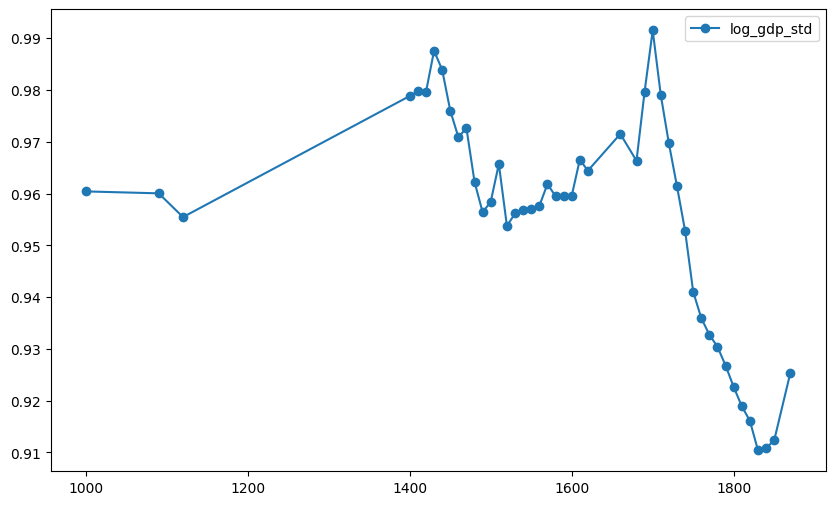

In [26]:
import matplotlib.pyplot as plt
df_filter = df[df["region_name"]=='Chinese world']

plt.figure(figsize=(10, 6))

#plt.plot(df_filter['year'], df_filter['N_est_log_std'], marker='o', label='N_est_log_std')
plt.plot(df_filter['year'], df_filter['log_gdp_std'], marker='o', label='log_gdp_std')
plt.legend()


In [31]:
df_filter

region_name  gdp_per_capita  year       pop       N_est  score  \
8   Chinese world     1225.107000  1000   59000.0    5.714897      2   
9   Chinese world     1221.711000  1090   66920.0    8.222018      2   
10  Chinese world     1180.959000  1120   69560.0   17.076022      4   
11  Chinese world     1404.246000  1400   94200.0   99.086584     17   
12  Chinese world     1414.000000  1410   95080.0   37.884777      6   
13  Chinese world     1412.000000  1420   95960.0   22.954625      2   
14  Chinese world     1498.000000  1430   96840.0   68.514283      8   
15  Chinese world     1458.000000  1440   97720.0   57.043824      9   
16  Chinese world     1375.380000  1450   98600.0   10.732786      2   
17  Chinese world     1324.000000  1460   99480.0   66.879352      9   
18  Chinese world     1341.000000  1470  100360.0   44.187453      6   
19  Chinese world     1242.000000  1480  101240.0   55.736977      8   
20  Chinese world     1189.000000  1490  102120.0   23.980308      3   
21  Chinese world     1207.278000  1500  103000.0   71.421743     10   
22  Chinese world     1274.000000  1510  108700.0   43.368320      5   
23  Chinese world     1166.000000  1520  114400.0  133.429094     16   
24  Chinese world     1187.000000  1530  120100.0  134.778598     16   
25  Chinese world     1193.000000  1540  125800.0  109.189453     14   
26  Chinese world     1195.000000  1550  131500.0  135.717717     16   
27  Chinese world     1200.000000  1560  137200.0   70.665297      8   
28  Chinese world     1237.842000  1570  142900.0  101.371906      6   
29  Chinese world     1217.000000  1580  148600.0   87.266732      9   
30  Chinese world     1217.000000  1590  154300.0   46.177344      6   
31  Chinese world     1217.466000  1600  160000.0   85.006807     13   
32  Chinese world     1282.000000  1610  157800.0   98.254774     12   
33  Chinese world     1262.000000  1620  155600.0  238.669163     27   
34  Chinese world     1330.000000  1660  146580.0  767.393516     78   
35  Chinese world     1280.000000  1680  141300.0  436.382441     46   
36  Chinese world     1413.000000  1690  140200.0  205.009986     21   
37  Chinese world     1542.633000  1700  138000.0  379.979875     41   
38  Chinese world     1406.000000  1710  158250.0  217.737398     18   
39  Chinese world     1312.000000  1720  178500.0   90.136164     10   
40  Chinese world     1234.000000  1730  198750.0  220.189506     23   
41  Chinese world     1158.000000  1740  219000.0  210.945616     18   
42  Chinese world     1061.250000  1750  239250.0  126.017546     13   
43  Chinese world     1022.000000  1760  259500.0  250.576236     27   
44  Chinese world      998.000000  1770  279750.0  319.464992     36   
45  Chinese world      981.000000  1780  300000.0  345.034331     38   
46  Chinese world      955.000000  1790  320250.0  306.709609     35   
47  Chinese world      926.259000  1800  340500.0  545.491854     62   
48  Chinese world      901.000000  1810  360750.0  243.220248     27   
49  Chinese world      882.438642  1820  383000.0  268.146476     33   
50  Chinese world      846.000000  1830  409000.0  453.452770     51   
51  Chinese world      849.000000  1840  412000.0  341.156020     39   
52  Chinese world      858.000000  1850  412000.0  389.391575     33   
53  Chinese world      945.149676  1870  360345.0  430.680976     40   

    score_cap  N_est_cap  century  score_log  ...  N_est_log  N_est_cap_log  \
8    0.000034   0.000097     1000   0.693147  ...   1.743076      -9.242216   
9    0.000030   0.000123     1100   0.693147  ...   2.106816      -9.004437   
10   0.000058   0.000245     1100   1.386294  ...   2.837675      -8.312270   
11   0.000180   0.001052     1400   2.833213  ...   4.595994      -6.857181   
12   0.000063   0.000398     1400   1.791759  ...   3.634549      -7.827925   
13   0.000021   0.000239     1400   0.693147  ...   3.133519      -8.338167   
14   0.000083   0.000707     1400   2.079442  ...   4.227042      -7

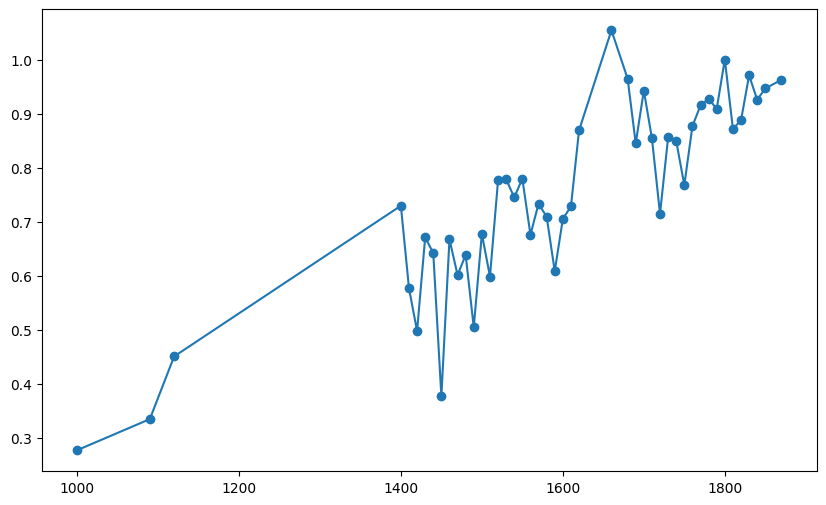

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(df_filter['year'], df_filter['N_est_log_std'], marker='o', label='N_est_log_std')


### Only good model

In [12]:
models = {}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


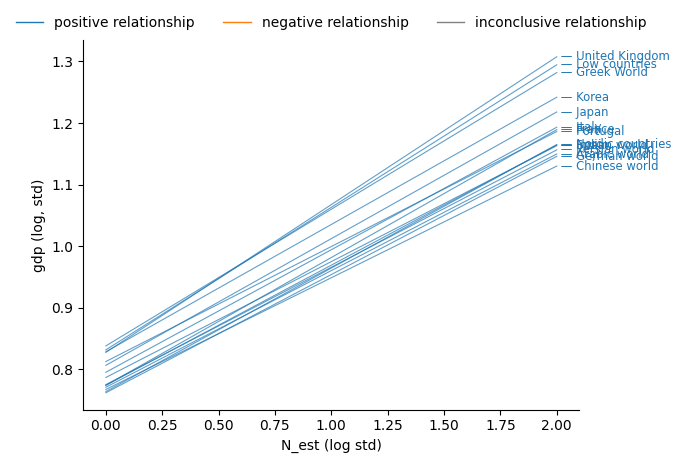

In [11]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency


posterior = az.extract(m_est_vs_fit)

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");


In [13]:
models["log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit

### COMPARISON

In [15]:
df.columns

Index(['region_name', 'gdp_per_capita', 'year', 'pop', 'N_est', 'score',
       'score_cap', 'N_est_cap', 'century', 'score_log', 'score_cap_log',
       'N_est_log', 'N_est_cap_log', 'score_log_std', 'score_cap_log_std',
       'N_est_std', 'N_est_log_std', 'N_est_cap_log_std', 'log_gdp',
       'log_gdp_std', 'gdp_std'],
      dtype='object')

In [16]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)

m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})


az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency


posterior = az.extract(m_est_vs_fit)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


KeyError: 'N_est_log_std|region_name'

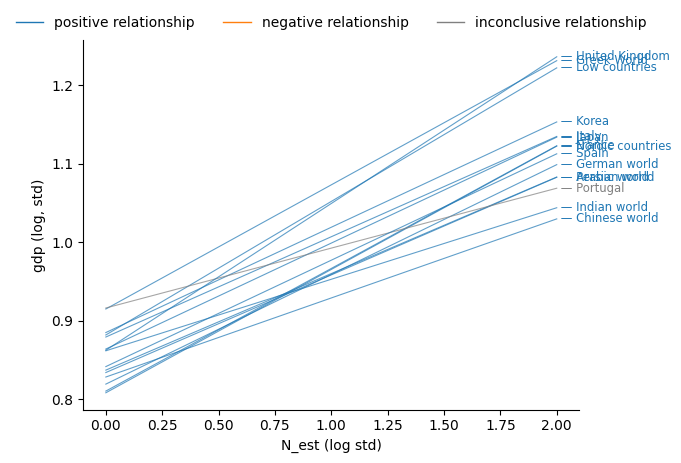

In [17]:



from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import xarray as xr

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");


In [18]:
models["log_gdp_std ~  score_log_std + (score_log_std|region_name)"] = m_est_vs_fit

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompa

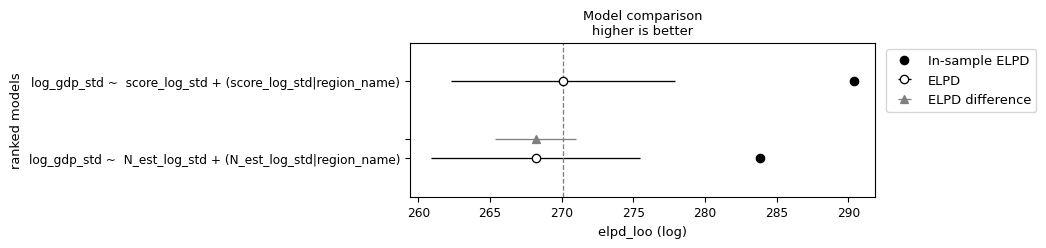

In [28]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True);

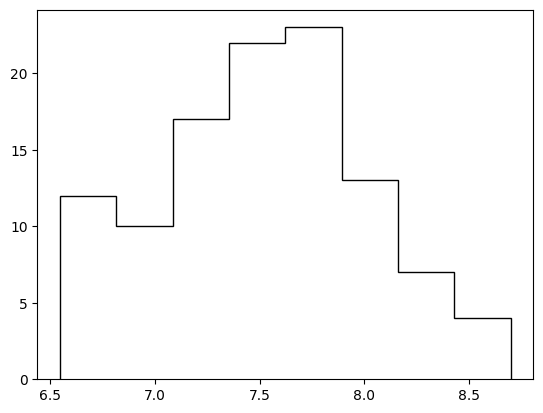

In [228]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

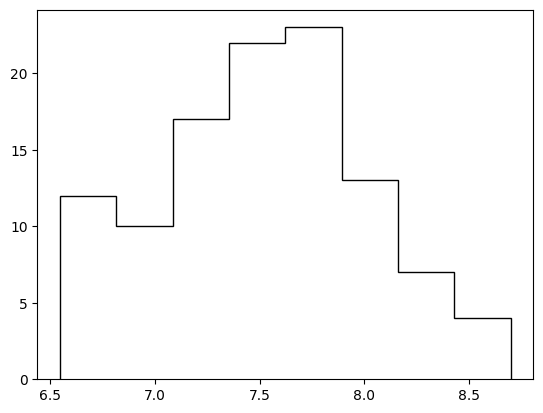

In [229]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

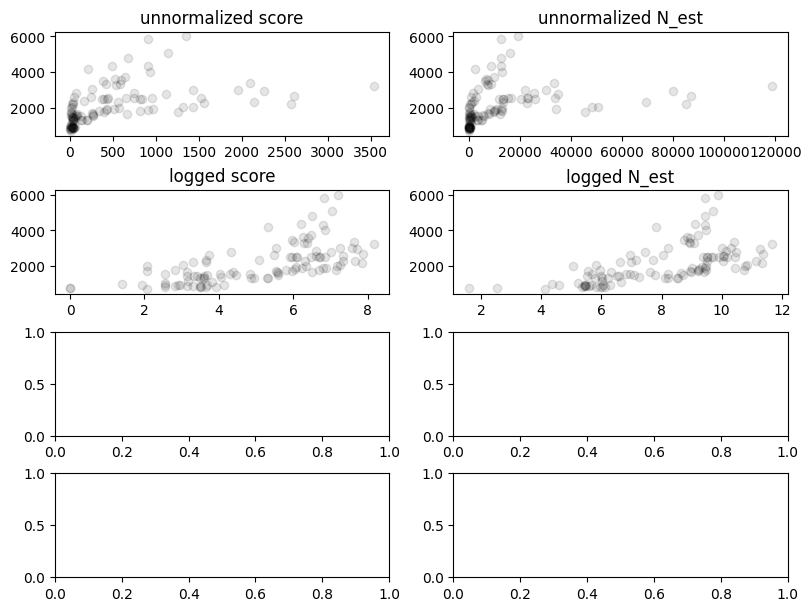

In [230]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [231]:
models = {}

The model is easily translated to Bambi with:

In [232]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

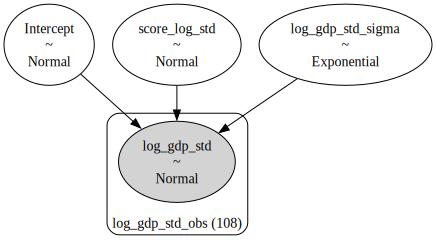

In [233]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [234]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


A quick summary of the model wth ArViz indicates that globally, the cultural production score has small yet pronounced effect:

In [235]:
az.summary(models["gdp ~ score_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.867  0.013   0.844    0.891        0.0      0.0   
score_log_std      0.133  0.012   0.110    0.155        0.0      0.0   
log_gdp_std_sigma  0.046  0.003   0.040    0.052        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            5987.0    3052.0    1.0  
score_log_std        5840.0    3055.0    1.0  
log_gdp_std_sigma    5004.0    3076.0    1.0

However, the model fit is not particularly good. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

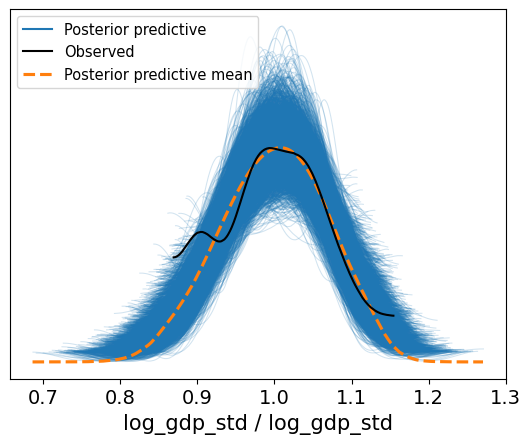

In [236]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

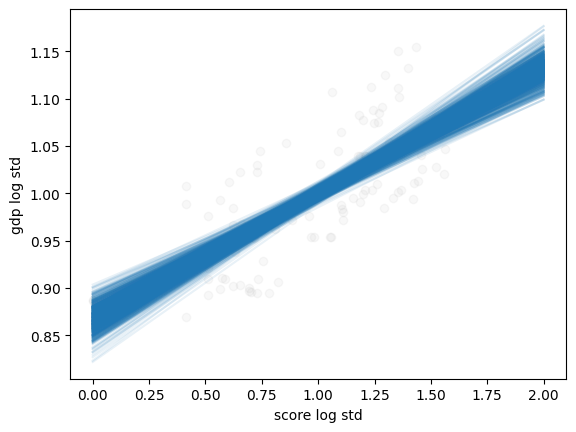

In [237]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [238]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Similar to the previous analysis, a cursory analysis of the new model seems to suggest a slightly weaker but still positive correlation between the cultural production score and GDP:

In [239]:
az.summary(models["gdp ~ N_est_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          0.814  0.018   0.782    0.849        0.0      0.0   
N_est_log_std      0.186  0.017   0.153    0.218        0.0      0.0   
log_gdp_std_sigma  0.047  0.003   0.041    0.053        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6491.0    3209.0    1.0  
N_est_log_std        6434.0    3105.0    1.0  
log_gdp_std_sigma    5836.0    2478.0    1.0

This relationship is visualized in the following graph:

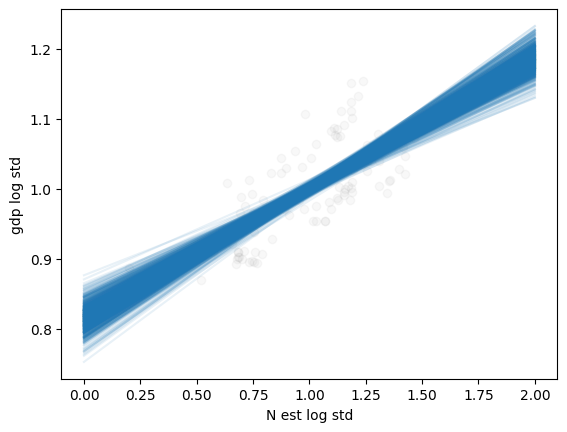

In [240]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

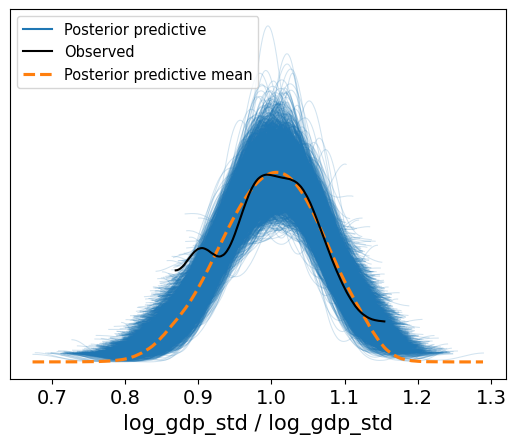

In [241]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable does not perform better than one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears evidence for a mildly positive relationship between the variables.

In [242]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


rank   elpd_waic    p_waic  elpd_diff    weight  \
gdp ~ score_log_std     0  179.105987  2.407899   0.000000  0.824863   
gdp ~ N_est_log_std     1  177.364000  2.392023   1.741987  0.175137   

                           se       dse  warning scale  
gdp ~ score_log_std  5.861141  0.000000    False   log  
gdp ~ N_est_log_std  6.358537  2.320826    False   log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


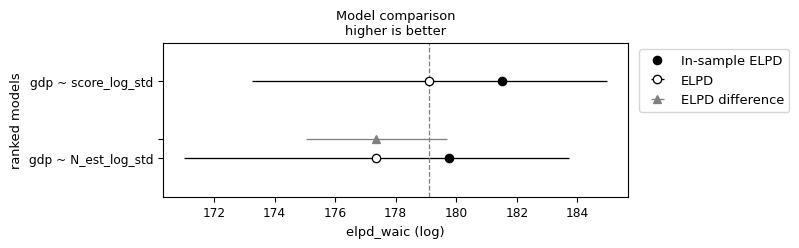

In [243]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [244]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

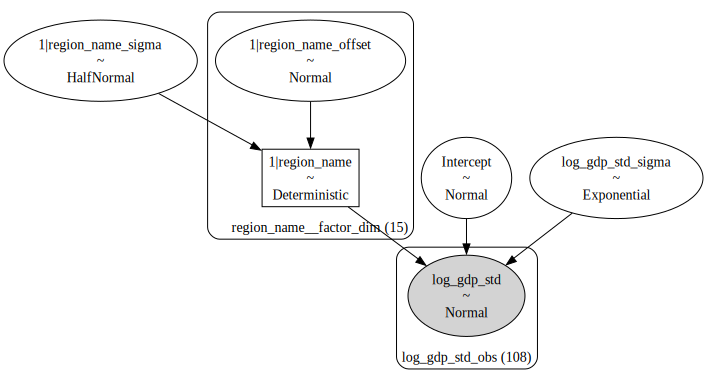

In [245]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [246]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.982  0.020   0.944    1.021      0.001   
log_gdp_std_sigma                0.025  0.002   0.021    0.028      0.000   
1|region_name_sigma              0.075  0.016   0.049    0.106      0.001   
1|region_name[Arabic world]     -0.068  0.025  -0.118   -0.022      0.001   
1|region_name[Chinese world]    -0.080  0.022  -0.121   -0.039      0.001   
1|region_name[France]            0.045  0.022   0.005    0.087      0.001   
1|region_name[German world]      0.045  0.022   0.003    0.083      0.001   
1|region_name[Greek World]       0.035  0.022  -0.005    0.077      0.001   
1|region_name[Indian world]     -0.072  0.022  -0.113   -0.031      0.001   
1|region_name[Italy]             0.060  0.022   0.017    0.099      0.001   
1|region_name[Japan]            -0.019  0.023  -0.064    0.022      0.001   
1|region_name[Korea]            -0.090  0.026  -0.139   -0.043      0.001   
1|region_name[Low countries]     0.098  0.022   0.057    0.139      0.001   
1|region_name[Nordic countries]  0.009  0.022  -0.030    0.051      0.001   
1|region_name[Persian world]    -0.073  0.025  -0.123   -0.028      0.001   
1|region_name[Portugal]         -0.012  0.022  -0.055    0.025      0.001   
1|region_name[Spain]             0.004  0.022  -0.037    0.044      0.001   
1|region_name[United Kingdom]    0.124  0.022   0.084    0.165      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0     965.0    1398.0   1.00  
log_gdp_std_sigma                    0.0    3577.0    3991.0   1.00  
1|region_name_sigma                  0.0     915.0    1701.0   1.01  
1|region_name[Arabic world]          0.0    1336.0    2501.0   1.00  
1|region_name[Chinese world]         0.0    1151.0    1911.0   1.00  
1|region_name[France]                0.0    1099.0    1725.0   1.00  
1|region_name[German world]          0.0    1069.0    1672.0   1.00  
1|region_name[Greek World]           0.0    1056.0    1791.0   1.00  
1|region_name[Indian world]          0.0    1062.0    1788.0   1.00  
1|region_name[Italy]                 0.0    1076.0    1787.0   1.00  
1|region_name[Japan]                 0.0    1167.0    1703.0   1.00  
1|region_name[Korea]                 0.0    1473.0    2810.0   1.00  
1|region_name[Low countries]         0.0    1088.0    1739.0   1.00  
1|region_name[Nordic countries]      0.0    1116.0    1682.0   1.00  
1|region_name[Persian world]         0.0    1710.0    2866.0   1.00  
1|region_name[Portugal]              0.0    1105.0    1743.0   1.00  
1|region_name[Spain]                 0.0    1104.0    1945.0   1.00  
1|region_name[United Kingdom]        0.0    1064.0    1841.0   1.00

The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

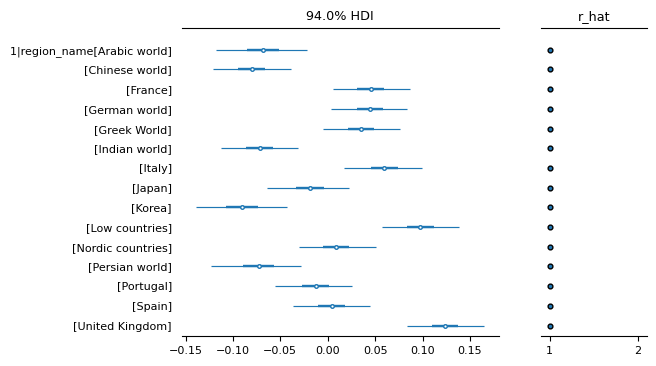

In [247]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


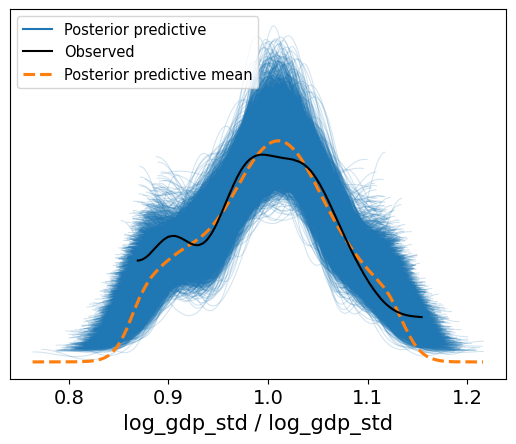

In [248]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [249]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

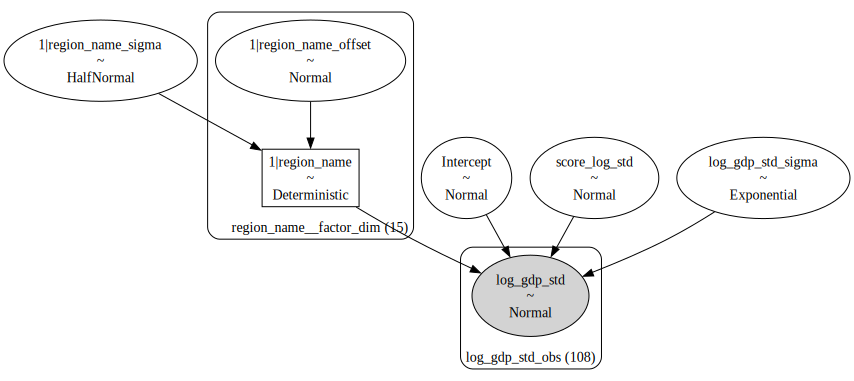

In [250]:
m_score_vi.build()
m_score_vi.graph()

In [251]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.858  0.019   0.822    0.892        0.0   
score_log_std                    0.139  0.015   0.109    0.167        0.0   
log_gdp_std_sigma                0.019  0.001   0.017    0.022        0.0   
1|region_name_sigma              0.045  0.010   0.029    0.065        0.0   
1|region_name[Arabic world]     -0.032  0.018  -0.066   -0.000        0.0   
1|region_name[Chinese world]    -0.057  0.014  -0.085   -0.032        0.0   
1|region_name[France]           -0.024  0.015  -0.051    0.006        0.0   
1|region_name[German world]     -0.038  0.016  -0.067   -0.007        0.0   
1|region_name[Greek World]       0.069  0.014   0.043    0.096        0.0   
1|region_name[Indian world]     -0.021  0.015  -0.049    0.007        0.0   
1|region_name[Italy]             0.007  0.014  -0.020    0.033        0.0   
1|region_name[Japan]             0.003  0.015  -0.024    0.031        0.0   
1|region_name[Korea]             0.026  0.021  -0.013    0.068        0.0   
1|region_name[Low countries]     0.059  0.014   0.032    0.086        0.0   
1|region_name[Nordic countries] -0.029  0.014  -0.055   -0.004        0.0   
1|region_name[Persian world]    -0.029  0.018  -0.061    0.005        0.0   
1|region_name[Portugal]          0.016  0.014  -0.011    0.041        0.0   
1|region_name[Spain]            -0.020  0.014  -0.046    0.005        0.0   
1|region_name[United Kingdom]    0.065  0.015   0.040    0.095        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    2102.0    3402.0    1.0  
score_log_std                        0.0    3058.0    3875.0    1.0  
log_gdp_std_sigma                    0.0    5258.0    5460.0    1.0  
1|region_name_sigma                  0.0    1608.0    2663.0    1.0  
1|region_name[Arabic world]          0.0    2694.0    4627.0    1.0  
1|region_name[Chinese world]         0.0    1938.0    3110.0    1.0  
1|region_name[France]                0.0    1838.0    3191.0    1.0  
1|region_name[German world]          0.0    1920.0    3080.0    1.0  
1|region_name[Greek World]           0.0    1802.0    3054.0    1.0  
1|region_name[Indian world]          0.0    1868.0    3156.0    1.0  
1|region_name[Italy]                 0.0    1815.0    3321.0    1.0  
1|region_name[Japan]                 0.0    1886.0    3081.0    1.0  
1|region_name[Korea]                 0.0    2537.0    4069.0    1.0  
1|region_name[Low countries]         0.0    1783.0    3169.0    1.0  
1|region_name[Nordic countries]      0.0    1766.0    3182.0    1.0  
1|region_name[Persian world]         0.0    2532.0    4377.0    1.0  
1|region_name[Portugal]              0.0    1791.0    3167.0    1.0  
1|region_name[Spain]                 0.0    1697.0    3193.0    1.0  
1|region_name[United Kingdom]        0.0    1866.0    3207.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.035 CI [0.032, 0.037]). It seems that the model fit has experienced a slight enhancement

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


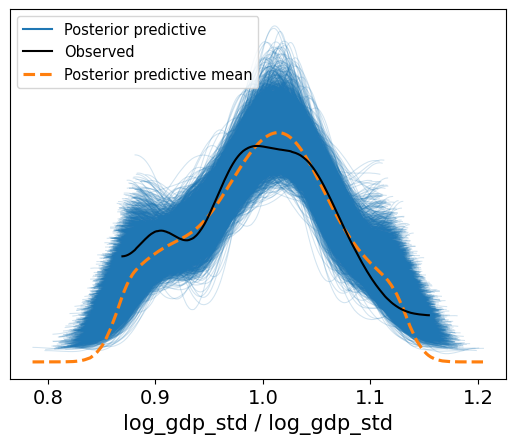

In [252]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

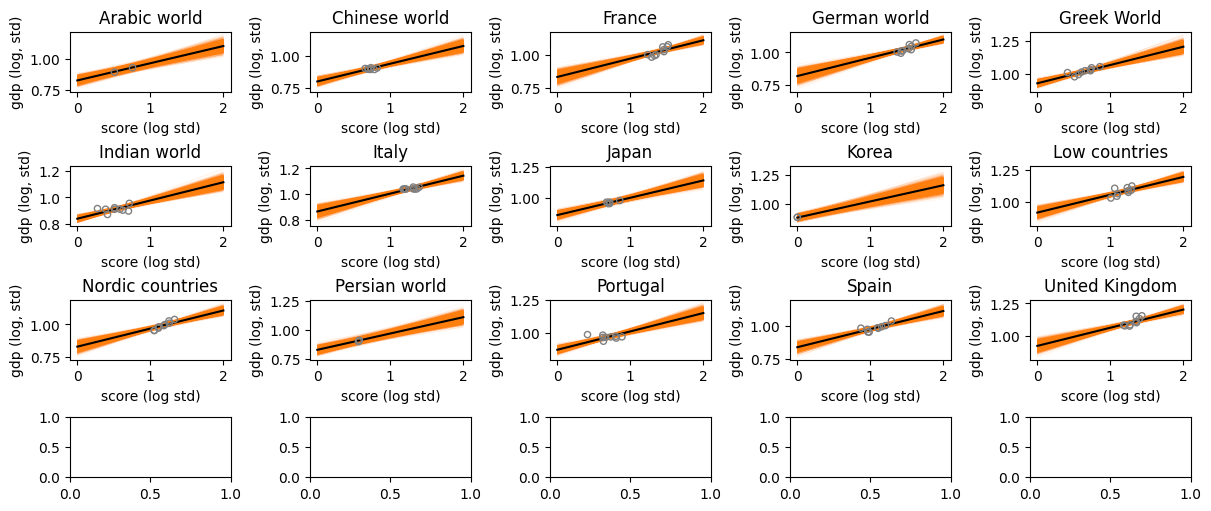

In [253]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

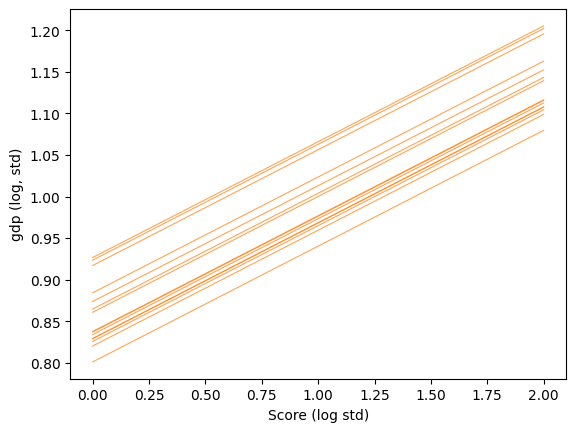

In [254]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [255]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [256]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        0.788  0.025   0.740    0.833        0.0   
N_est_log_std                    0.211  0.023   0.168    0.255        0.0   
log_gdp_std_sigma                0.019  0.001   0.016    0.022        0.0   
1|region_name_sigma              0.048  0.011   0.030    0.067        0.0   
1|region_name[Arabic world]     -0.034  0.018  -0.066    0.001        0.0   
1|region_name[Chinese world]    -0.043  0.015  -0.070   -0.015        0.0   
1|region_name[France]           -0.019  0.016  -0.049    0.010        0.0   
1|region_name[German world]     -0.052  0.018  -0.085   -0.018        0.0   
1|region_name[Greek World]       0.059  0.014   0.032    0.087        0.0   
1|region_name[Indian world]     -0.016  0.015  -0.046    0.012        0.0   
1|region_name[Italy]            -0.008  0.016  -0.037    0.022        0.0   
1|region_name[Japan]             0.015  0.016  -0.014    0.045        0.0   
1|region_name[Korea]             0.041  0.023  -0.003    0.083        0.0   
1|region_name[Low countries]     0.065  0.014   0.040    0.094        0.0   
1|region_name[Nordic countries] -0.036  0.015  -0.063   -0.008        0.0   
1|region_name[Persian world]    -0.027  0.018  -0.061    0.008        0.0   
1|region_name[Portugal]          0.005  0.014  -0.021    0.032        0.0   
1|region_name[Spain]            -0.031  0.015  -0.059   -0.004        0.0   
1|region_name[United Kingdom]    0.073  0.015   0.044    0.101        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    2583.0    3388.0    1.0  
N_est_log_std                        0.0    3019.0    3417.0    1.0  
log_gdp_std_sigma                    0.0    4412.0    5016.0    1.0  
1|region_name_sigma                  0.0    1580.0    2675.0    1.0  
1|region_name[Arabic world]          0.0    2823.0    4482.0    1.0  
1|region_name[Chinese world]         0.0    2153.0    2910.0    1.0  
1|region_name[France]                0.0    2080.0    3357.0    1.0  
1|region_name[German world]          0.0    2171.0    3387.0    1.0  
1|region_name[Greek World]           0.0    2048.0    2843.0    1.0  
1|region_name[Indian world]          0.0    2078.0    2960.0    1.0  
1|region_name[Italy]                 0.0    2039.0    3267.0    1.0  
1|region_name[Japan]                 0.0    2251.0    3067.0    1.0  
1|region_name[Korea]                 0.0    2827.0    3951.0    1.0  
1|region_name[Low countries]         0.0    2017.0    3069.0    1.0  
1|region_name[Nordic countries]      0.0    1979.0    3050.0    1.0  
1|region_name[Persian world]         0.0    2833.0    3892.0    1.0  
1|region_name[Portugal]              0.0    2032.0    3161.0    1.0  
1|region_name[Spain]                 0.0    2005.0    3149.0    1.0  
1|region_name[United Kingdom]        0.0    2059.0    3280.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

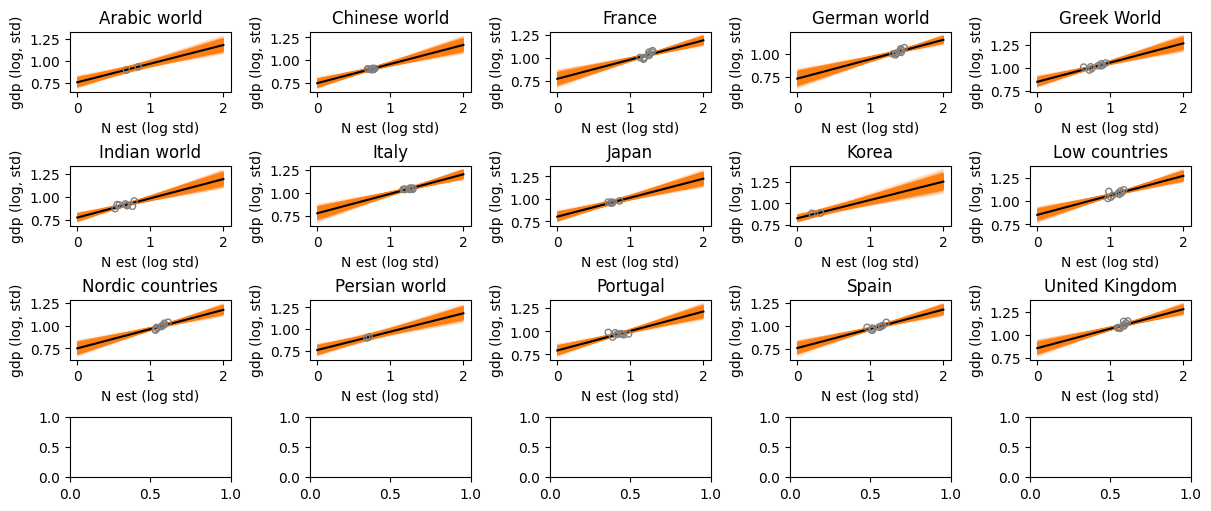

In [257]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

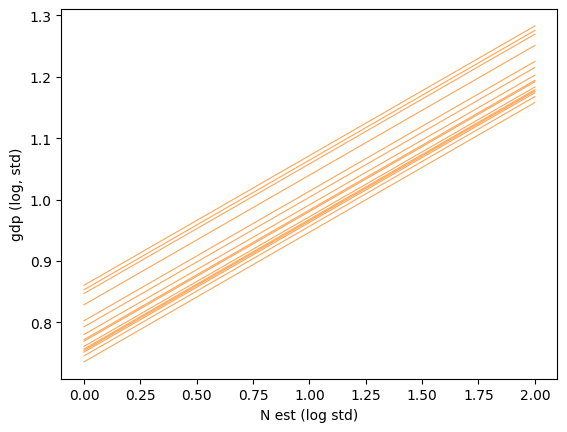

In [258]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [259]:
waic_compare = az.compare(models, ic='LOO')

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


In [260]:
waic_compare

rank    elpd_loo      p_loo  \
log_gdp_std ~ N_est_log_std + (1|region_name)     0  268.184460  14.307154   
log_gdp_std ~ score_log_std + (1|region_name)     1  265.528960  14.515635   
log_gdp_std ~ (1|region_name)                     2  239.207057  13.364283   
gdp ~ score_log_std                               3  179.099235   2.414651   
gdp ~ N_est_log_std                               4  177.357909   2.398114   

                                               elpd_diff        weight  \
log_gdp_std ~ N_est_log_std + (1|region_name)   0.000000  7.583301e-01   
log_gdp_std ~ score_log_std + (1|region_name)   2.655501  1.877230e-01   
log_gdp_std ~ (1|region_name)                  28.977403  5.394689e-02   
gdp ~ score_log_std                            89.085226  2.827282e-12   
gdp ~ N_est_log_std                            90.826551  1.610209e-10   

                                                     se       dse  warning  \
log_gdp_std ~ N_est_log_std + (1|region_name)  7.237373  0.000000    False   
log_gdp_std ~ score_log_std + (1|region_name)  7.946752  2.911403    False   
log_gdp_std ~ (1|region_name)                  6.835149  7.244382    False   
gdp ~ score_log_std                            5.862221  7.336414    False   
gdp ~ N_est_log_std                            6.359070  7.503052    False   

                                              scale  
log_gdp_std ~ N_est_log_std + (1|region_name)   log  
log_gdp_std ~ score_log_std + (1|region_name)   log  
log_gdp_std ~ (1|region_name)                   log  
gdp ~ score_log_std                             log  
gdp ~ N_est_log_std                             log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


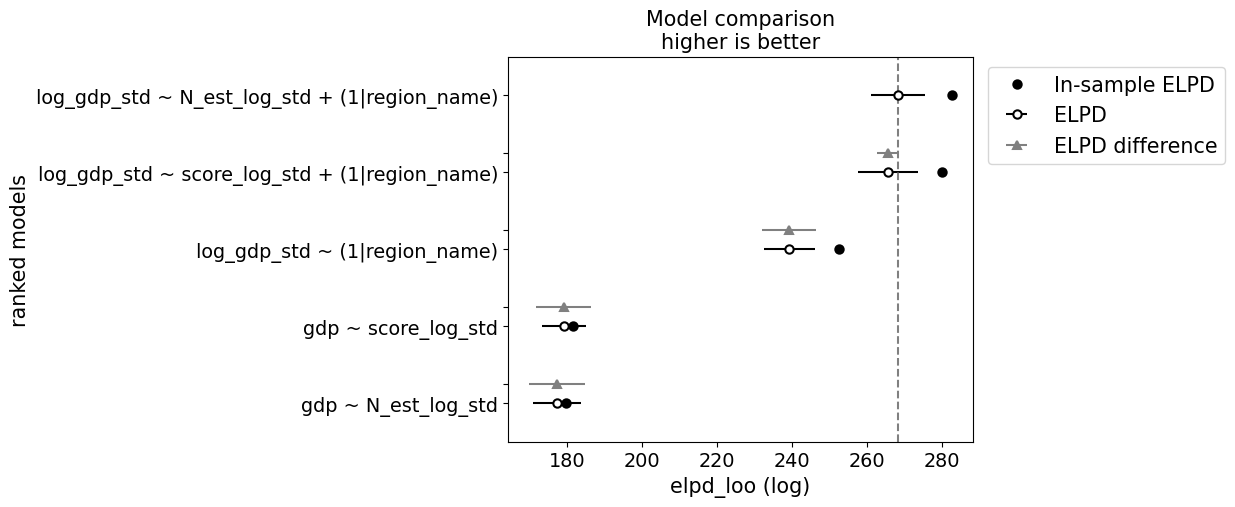

In [261]:
az.plot_compare(waic_compare, insample_dev=True);

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


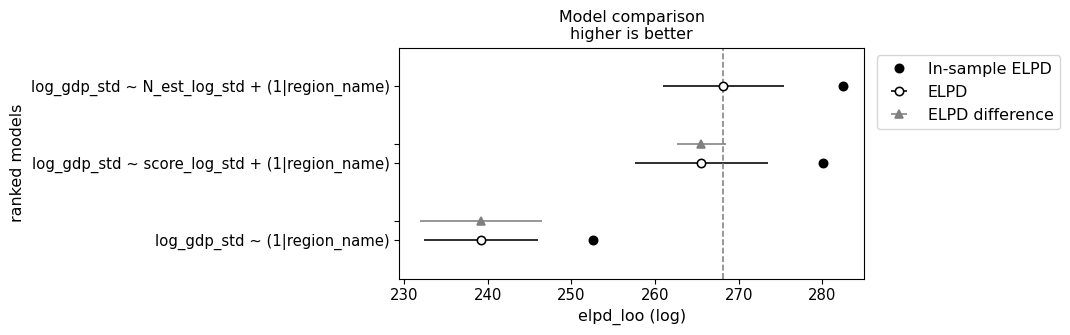

In [262]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [263]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs

       Formula: log_gdp_std ~ score_log_std + (score_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

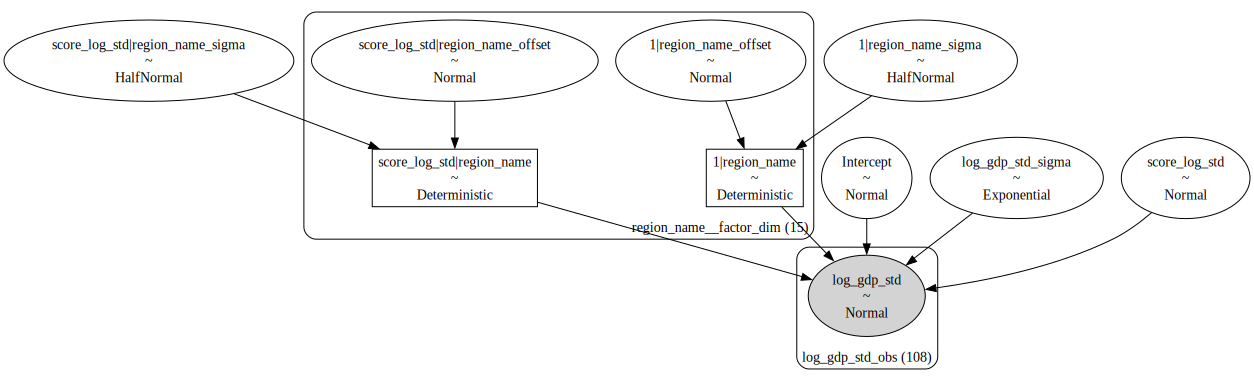

In [264]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [265]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.854  0.025   0.814    0.900   
score_log_std                                0.135  0.022   0.094    0.176   
log_gdp_std_sigma                            0.018  0.002   0.015    0.021   
1|region_name_sigma                          0.051  0.024   0.015    0.096   
score_log_std|region_name_sigma              0.049  0.024   0.013    0.103   
1|region_name[Arabic world]                 -0.021  0.028  -0.078    0.030   
1|region_name[Chinese world]                -0.026  0.037  -0.095    0.039   
1|region_name[France]                       -0.046  0.044  -0.134    0.026   
1|region_name[German world]                 -0.036  0.041  -0.114    0.040   
1|region_name[Greek World]                   0.061  0.030   0.004    0.114   
1|region_name[Indian world]                  0.008  0.032  -0.045    0.060   
1|region_name[Italy]                         0.027  0.048  -0.056    0.110   
1|region_name[Japan]                         0.009  0.032  -0.045    0.082   
1|region_name[Korea]                         0.030  0.026  -0.017    0.079   
1|region_name[Low countries]                 0.025  0.035  -0.040    0.093   
1|region_name[Nordic countries]             -0.048  0.040  -0.130    0.018   
1|region_name[Persian world]                -0.016  0.037  -0.085    0.043   
1|region_name[Portugal]                      0.061  0.038  -0.004    0.136   
1|region_name[Spain]                        -0.014  0.030  -0.070    0.043   
1|region_name[United Kingdom]                0.008  0.042  -0.070    0.088   
score_log_std|region_name[Arabic world]     -0.009  0.041  -0.089    0.071   
score_log_std|region_name[Chinese world]    -0.035  0.041  -0.117    0.037   
score_log_std|region_name[France]            0.023  0.035  -0.035    0.096   
score_log_std|region_name[German world]      0.005  0.030  -0.050    0.063   
score_log_std|region_name[Greek World]       0.023  0.034  -0.040    0.089   
score_log_std|region_name[Indian world]     -0.045  0.038  -0.123    0.021   
score_log_std|region_name[Italy]            -0.009  0.035  -0.081    0.055   
score_log_std|region_name[Japan]             0.001  0.037  -0.072    0.071   
score_log_std|region_name[Korea]            -0.001  0.052  -0.098    0.101   
score_log_std|region_name[Low countries]     0.037  0.033  -0.019    0.102   
score_log_std|region_name[Nordic countries]  0.024  0.037  -0.035    0.101   
score_log_std|region_name[Persian world]    -0.014  0.050  -0.111    0.084   
score_log_std|region_name[Portugal]         -0.058  0.044  -0.144    0.012   
score_log_std|region_name[Spain]             0.002  0.030  -0.053    0.064   
score_log_std|region_name[United Kingdom]    0.052  0.033  -0.006    0.116   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.002    0.001     387.0   
score_log_std                                    0.000    0.000    3465.0   
log_gdp_std_sigma                                0.000    0.000    2017.0   
1|region_name_sigma                              0.002    0.002     355.0   
score_log_std|region_name_sigma                  0.001    0.001     423.0   
1|region_name[Arabic world]                      0.001    0.000    2056.0   
1|region_name[Chinese world]                     0.003    0.002     312.0   
1|region_name[France]                            0.001    0.001    1481.0   
1|region_name[German world]                      0.001    0.001    3529.0   
1|region_name[Greek World]                       0.002    0.002     377.0   
1|region_name[Indian world]                      0.003    0.004     352.0   
1|region_name[Italy]                             0.004    0.005     378.0   
1|region_name[Japan]                             0.002    0.001     597.0   
1|region_name[Korea]                             0.002    0.002     421.0   
1|region_name[Low countries]                     0.001    0.000    4206.0   
1|reg

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


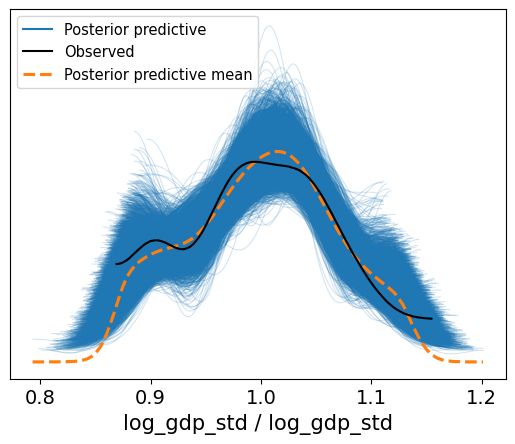

In [266]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

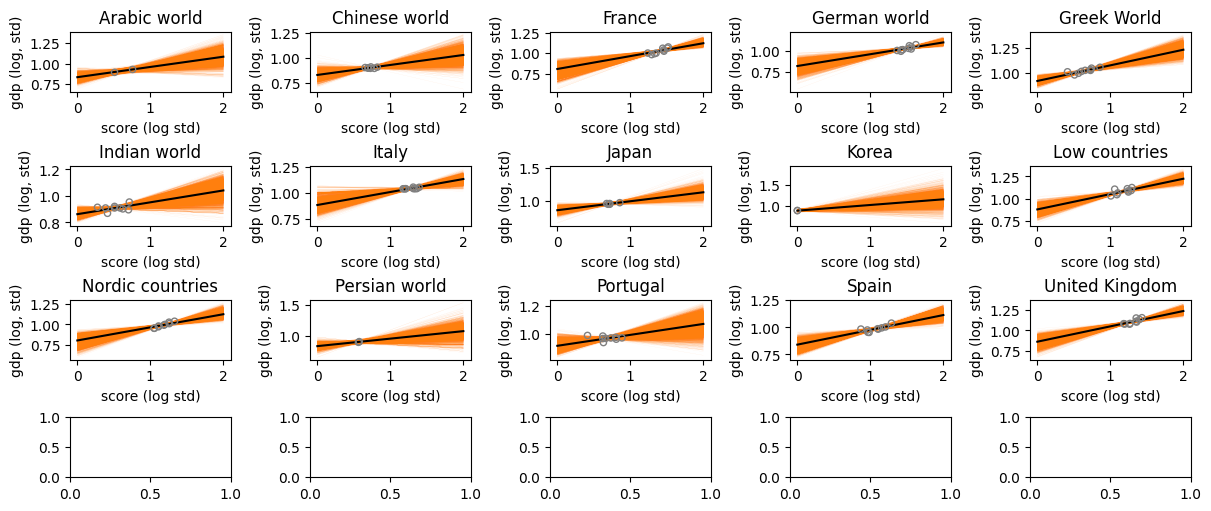

In [267]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

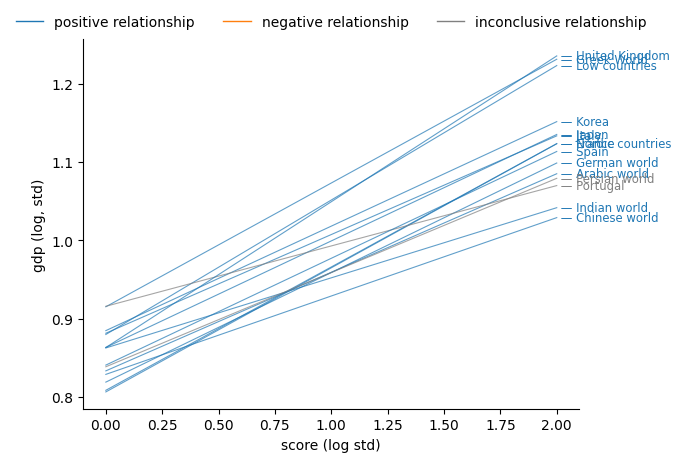

In [268]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

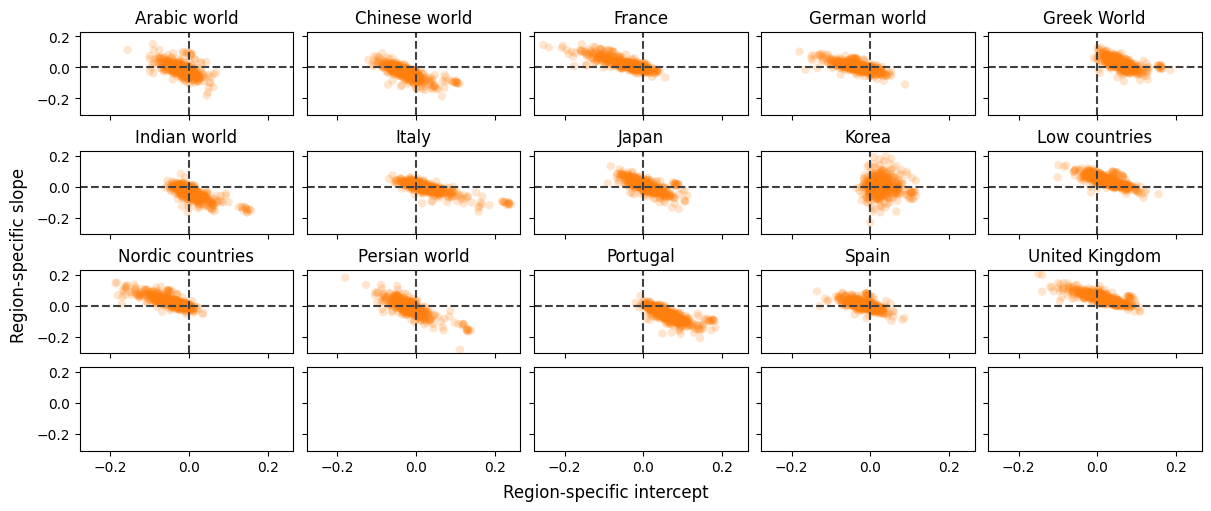

In [269]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

# Good Model

In [342]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 378
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [347]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit

az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 72 seconds.


mean     sd  hdi_3%  hdi_97%  \
Intercept                                    0.902  0.023   0.859    0.948   
N_est_log_std                                0.075  0.027   0.021    0.123   
log_gdp_std_sigma                            0.021  0.001   0.020    0.023   
1|region_name_sigma                          0.078  0.019   0.045    0.113   
N_est_log_std|region_name_sigma              0.091  0.023   0.053    0.134   
1|region_name[Arabic world]                  0.001  0.043  -0.080    0.081   
1|region_name[Chinese world]                 0.076  0.033   0.014    0.139   
1|region_name[France]                       -0.070  0.033  -0.133   -0.007   
1|region_name[German world]                 -0.062  0.037  -0.132    0.006   
1|region_name[Greek World]                   0.035  0.025  -0.014    0.082   
1|region_name[Indian world]                  0.022  0.034  -0.038    0.090   
1|region_name[Italy]                         0.054  0.049  -0.033    0.153   
1|region_name[Japan]                        -0.038  0.039  -0.108    0.040   
1|region_name[Korea]                        -0.021  0.034  -0.087    0.041   
1|region_name[Low countries]                 0.065  0.034   0.004    0.131   
1|region_name[Nordic countries]              0.072  0.027   0.023    0.125   
1|region_name[Persian world]                -0.025  0.053  -0.123    0.078   
1|region_name[Portugal]                      0.076  0.030   0.019    0.132   
1|region_name[Spain]                        -0.050  0.035  -0.117    0.014   
1|region_name[United Kingdom]               -0.134  0.032  -0.192   -0.073   
N_est_log_std|region_name[Arabic world]     -0.044  0.054  -0.146    0.052   
N_est_log_std|region_name[Chinese world]    -0.123  0.041  -0.198   -0.045   
N_est_log_std|region_name[France]            0.070  0.033   0.006    0.132   
N_est_log_std|region_name[German world]      0.043  0.034  -0.019    0.106   
N_est_log_std|region_name[Greek World]       0.017  0.031  -0.042    0.074   
N_est_log_std|region_name[Indian world]     -0.070  0.044  -0.159    0.009   
N_est_log_std|region_name[Italy]            -0.004  0.041  -0.081    0.074   
N_est_log_std|region_name[Japan]             0.044  0.049  -0.049    0.133   
N_est_log_std|region_name[Korea]            -0.018  0.081  -0.179    0.128   
N_est_log_std|region_name[Low countries]     0.040  0.035  -0.030    0.103   
N_est_log_std|region_name[Nordic countries] -0.054  0.030  -0.108    0.005   
N_est_log_std|region_name[Persian world]    -0.025  0.067  -0.156    0.100   
N_est_log_std|region_name[Portugal]         -0.067  0.035  -0.131   -0.002   
N_est_log_std|region_name[Spain]             0.031  0.036  -0.036    0.099   
N_est_log_std|region_name[United Kingdom]    0.177  0.033   0.117    0.243   

                                             mcse_mean  mcse_sd  ess_bulk  \
Intercept                                        0.000    0.000    3192.0   
N_est_log_std                                    0.001    0.000    2658.0   
log_gdp_std_sigma                                0.000    0.000   12160.0   
1|region_name_sigma                              0.000    0.000    2970.0   
N_est_log_std|region_name_sigma                  0.000    0.000    2957.0   
1|region_name[Arabic world]                      0.001    0.000    5727.0   
1|region_name[Chinese world]                     0.000    0.000    4695.0   
1|region_name[France]                            0.000    0.000    5512.0   
1|region_name[German world]                      0.000    0.000    6510.0   
1|region_name[Greek World]                       0.000    0.000    3482.0   
1|region_name[Indian world]                      0.000    0.000    5925.0   
1|region_name[Italy]                             0.001    0.000    7481.0   
1|region_name[Japan]                             0.001    0.000    6078.0   
1|region_name[Korea]                             0.000    0.000    4916.0   
1|region_name[Low countries]                     0.000    0.000    5318.0   
1|reg

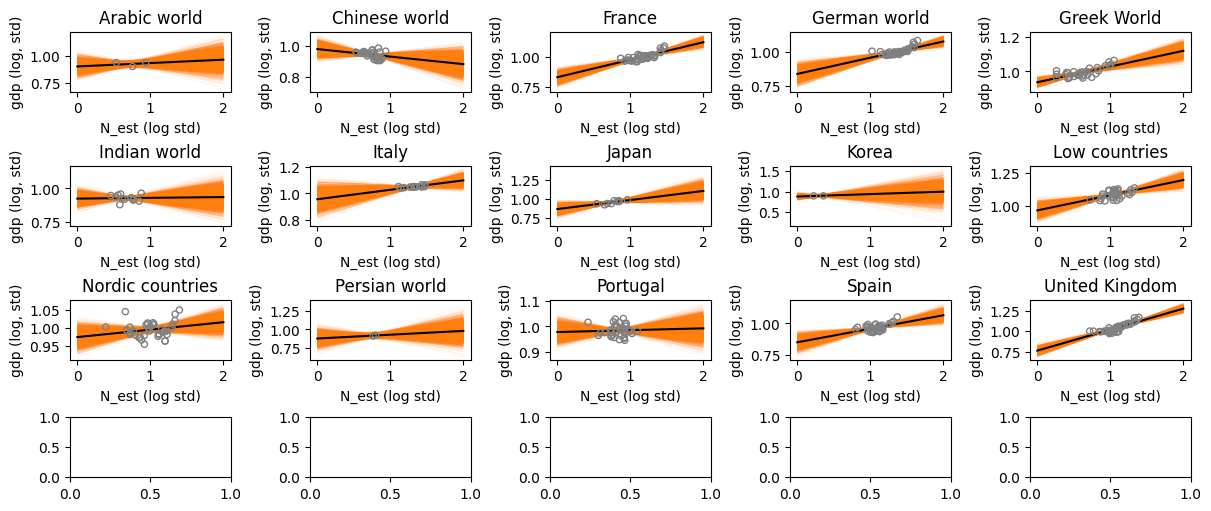

In [344]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)

    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")

    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

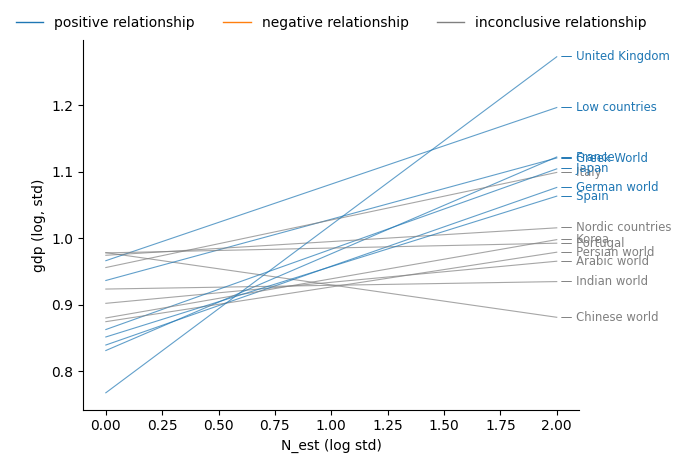

In [349]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score = np.array([0, 2])
score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [1]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

NameError: name 'az' is not defined

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


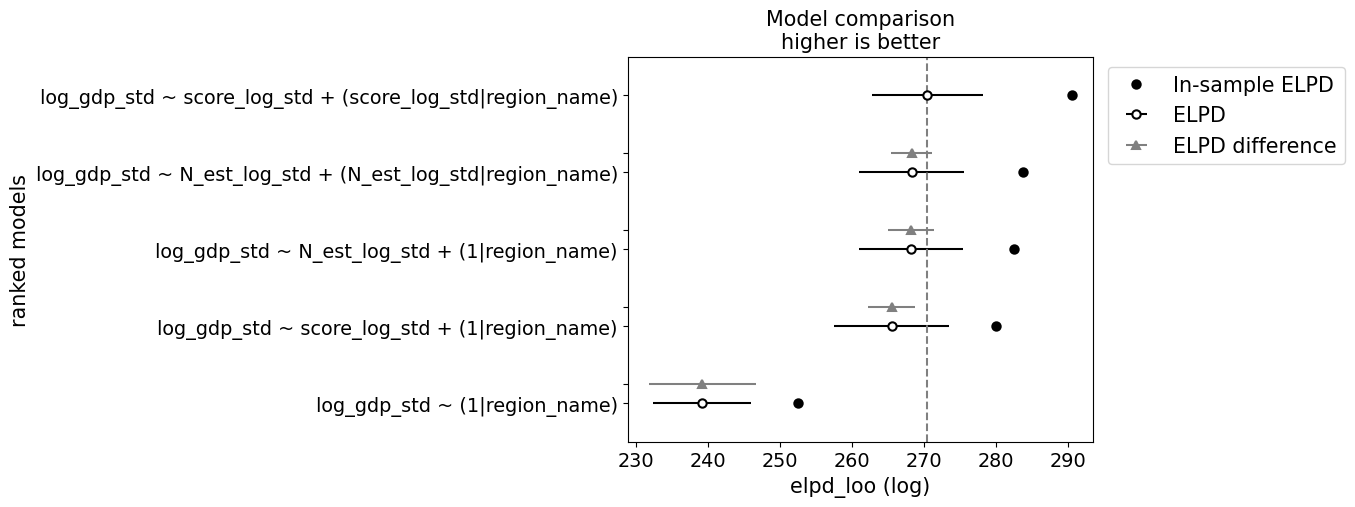

In [276]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

# Cultural score per capita

In the analsyses above, we correlated a global cultural production score (both corrected and uncorrected) with the GDP scores per capita. These scores ignore differences in population size. As a final step in the analysis, we repeat the analyses with varying intercepts and varying slopes, but swapping the unnormalized cultural production scores for the scores per capita. We begin with the uncorrected score:

In [277]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vi = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_cap_vi

       Formula: log_gdp_std ~ score_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

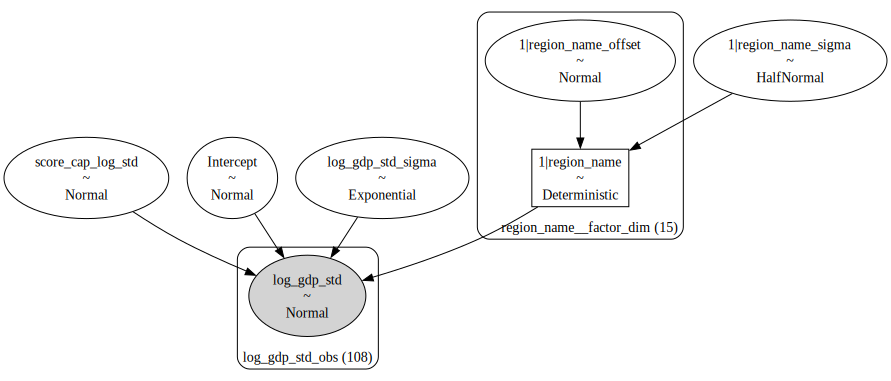

In [278]:
m_score_cap_vi.build()
m_score_cap_vi.graph()

In [279]:
m_score_cap_vi_fit = m_score_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_cap_log_std + (1|region_name)"] = m_score_cap_vi_fit
az.summary(m_score_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        1.054  0.023   1.012    1.098      0.001   
score_cap_log_std               -0.066  0.016  -0.096   -0.036      0.000   
log_gdp_std_sigma                0.024  0.002   0.021    0.027      0.000   
1|region_name_sigma              0.053  0.013   0.033    0.079      0.000   
1|region_name[Arabic world]     -0.051  0.021  -0.092   -0.012      0.000   
1|region_name[Chinese world]    -0.033  0.021  -0.071    0.006      0.000   
1|region_name[France]            0.018  0.018  -0.014    0.052      0.000   
1|region_name[German world]      0.011  0.018  -0.024    0.045      0.000   
1|region_name[Greek World]       0.066  0.018   0.031    0.099      0.000   
1|region_name[Indian world]     -0.030  0.020  -0.066    0.006      0.000   
1|region_name[Italy]             0.035  0.017   0.002    0.068      0.000   
1|region_name[Japan]            -0.004  0.018  -0.039    0.030      0.000   
1|region_name[Korea]            -0.038  0.024  -0.082    0.010      0.000   
1|region_name[Low countries]     0.060  0.019   0.024    0.095      0.000   
1|region_name[Nordic countries] -0.025  0.018  -0.058    0.010      0.000   
1|region_name[Persian world]    -0.063  0.021  -0.103   -0.024      0.000   
1|region_name[Portugal]         -0.022  0.017  -0.055    0.008      0.000   
1|region_name[Spain]            -0.014  0.017  -0.045    0.018      0.000   
1|region_name[United Kingdom]    0.097  0.018   0.065    0.131      0.000   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1787.0    2828.0    1.0  
score_cap_log_std                    0.0    2630.0    3542.0    1.0  
log_gdp_std_sigma                    0.0    4309.0    4461.0    1.0  
1|region_name_sigma                  0.0    1446.0    2438.0    1.0  
1|region_name[Arabic world]          0.0    2431.0    3808.0    1.0  
1|region_name[Chinese world]         0.0    1996.0    3441.0    1.0  
1|region_name[France]                0.0    1683.0    2625.0    1.0  
1|region_name[German world]          0.0    1752.0    2665.0    1.0  
1|region_name[Greek World]           0.0    1967.0    2967.0    1.0  
1|region_name[Indian world]          0.0    1955.0    3147.0    1.0  
1|region_name[Italy]                 0.0    1746.0    2639.0    1.0  
1|region_name[Japan]                 0.0    1881.0    3028.0    1.0  
1|region_name[Korea]                 0.0    2813.0    3882.0    1.0  
1|region_name[Low countries]         0.0    1782.0    2727.0    1.0  
1|region_name[Nordic countries]      0.0    1737.0    2990.0    1.0  
1|region_name[Persian world]         0.0    2832.0    3853.0    1.0  
1|region_name[Portugal]              0.0    1663.0    2648.0    1.0  
1|region_name[Spain]                 0.0    1614.0    2783.0    1.0  
1|region_name[United Kingdom]        0.0    1764.0    2787.0    1.0

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.023 CI [0.022, 0.025]). It seems that the model fit is decent. 

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


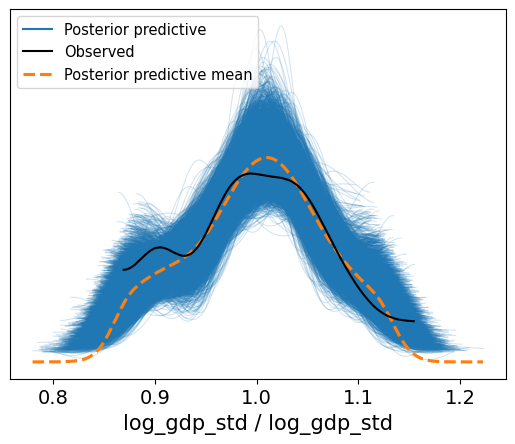

In [280]:
m_score_cap_vi.predict(m_score_cap_vi_fit, kind="pps")
az.plot_ppc(m_score_cap_vi_fit);

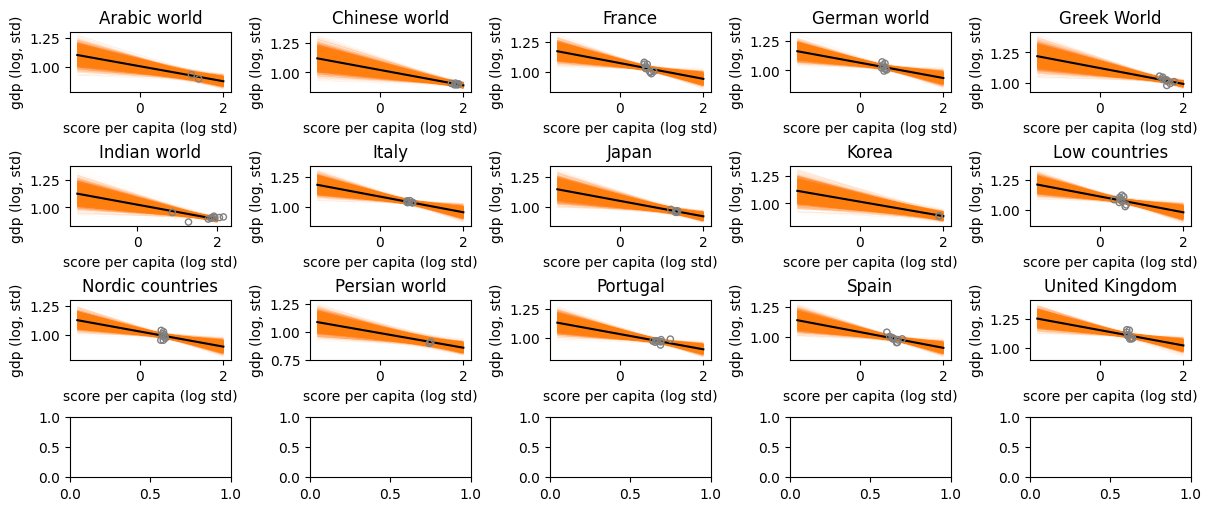

In [281]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

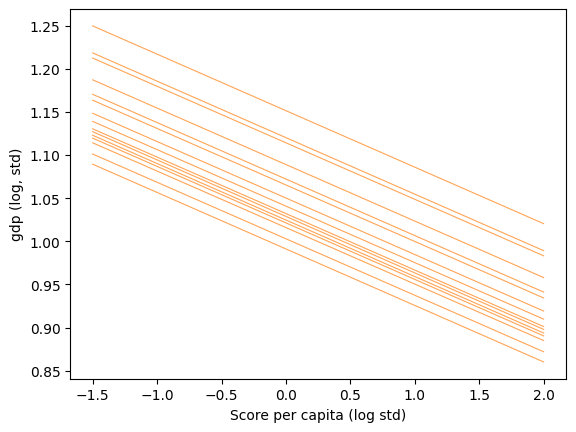

In [282]:
posterior = az.extract(m_score_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score per capita (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [283]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vi = bmb.Model(
    "log_gdp_std ~ N_est_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_cap_vi

       Formula: log_gdp_std ~ N_est_cap_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [284]:
m_est_cap_vi_fit = m_est_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (1|region_name)"] = m_est_cap_vi_fit
az.summary(m_est_cap_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                        1.021  0.015   0.993    1.051        0.0   
N_est_cap_log_std               -0.029  0.006  -0.041   -0.018        0.0   
log_gdp_std_sigma                0.024  0.002   0.020    0.027        0.0   
1|region_name_sigma              0.050  0.012   0.031    0.072        0.0   
1|region_name[Arabic world]     -0.050  0.020  -0.088   -0.013        0.0   
1|region_name[Chinese world]    -0.021  0.020  -0.056    0.018        0.0   
1|region_name[France]            0.016  0.016  -0.012    0.049        0.0   
1|region_name[German world]     -0.002  0.018  -0.033    0.033        0.0   
1|region_name[Greek World]       0.064  0.016   0.035    0.096        0.0   
1|region_name[Indian world]     -0.023  0.018  -0.056    0.012        0.0   
1|region_name[Italy]             0.023  0.016  -0.008    0.055        0.0   
1|region_name[Japan]             0.003  0.017  -0.030    0.033        0.0   
1|region_name[Korea]            -0.025  0.023  -0.069    0.020        0.0   
1|region_name[Low countries]     0.058  0.017   0.028    0.092        0.0   
1|region_name[Nordic countries] -0.033  0.017  -0.066   -0.001        0.0   
1|region_name[Persian world]    -0.060  0.020  -0.100   -0.023        0.0   
1|region_name[Portugal]         -0.028  0.015  -0.058    0.001        0.0   
1|region_name[Spain]            -0.022  0.016  -0.051    0.009        0.0   
1|region_name[United Kingdom]    0.097  0.016   0.067    0.127        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1572.0    2430.0    1.0  
N_est_cap_log_std                    0.0    2383.0    3307.0    1.0  
log_gdp_std_sigma                    0.0    4880.0    5009.0    1.0  
1|region_name_sigma                  0.0    1562.0    2475.0    1.0  
1|region_name[Arabic world]          0.0    3001.0    4395.0    1.0  
1|region_name[Chinese world]         0.0    2212.0    3518.0    1.0  
1|region_name[France]                0.0    1856.0    2945.0    1.0  
1|region_name[German world]          0.0    1819.0    2735.0    1.0  
1|region_name[Greek World]           0.0    2025.0    3092.0    1.0  
1|region_name[Indian world]          0.0    2097.0    3479.0    1.0  
1|region_name[Italy]                 0.0    1938.0    2882.0    1.0  
1|region_name[Japan]                 0.0    2398.0    3928.0    1.0  
1|region_name[Korea]                 0.0    2528.0    4189.0    1.0  
1|region_name[Low countries]         0.0    1842.0    3059.0    1.0  
1|region_name[Nordic countries]      0.0    1831.0    3034.0    1.0  
1|region_name[Persian world]         0.0    3098.0    4246.0    1.0  
1|region_name[Portugal]              0.0    1841.0    2588.0    1.0  
1|region_name[Spain]                 0.0    1801.0    2761.0    1.0  
1|region_name[United Kingdom]        0.0    1993.0    2767.0    1.0

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

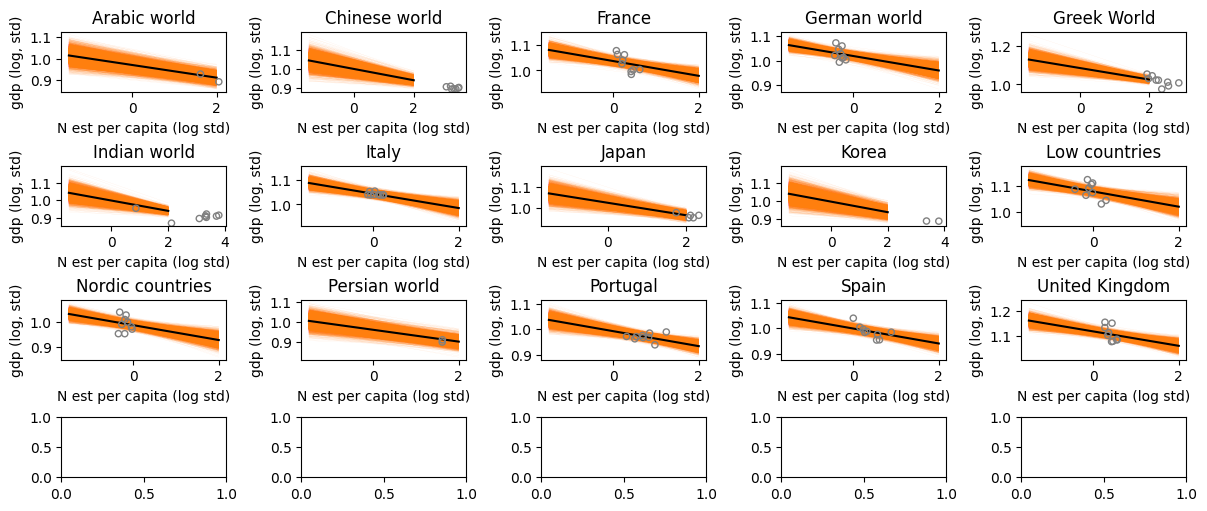

In [285]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est per capita (log std)", title=region_name)

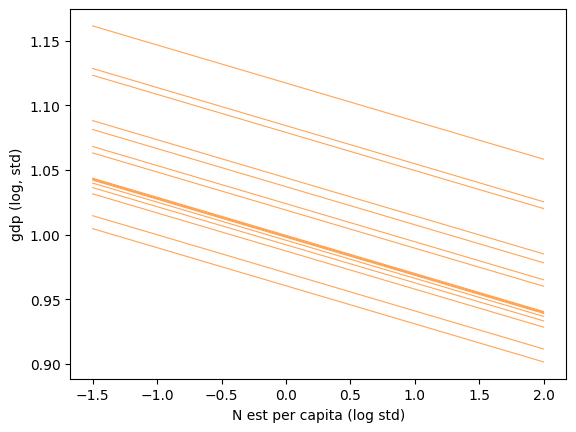

In [286]:
posterior = az.extract(m_est_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est per capita (log std)");

### Varying Slopes for Cultural Production in Different Regions

In [287]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vs = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_cap_vs

       Formula: log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

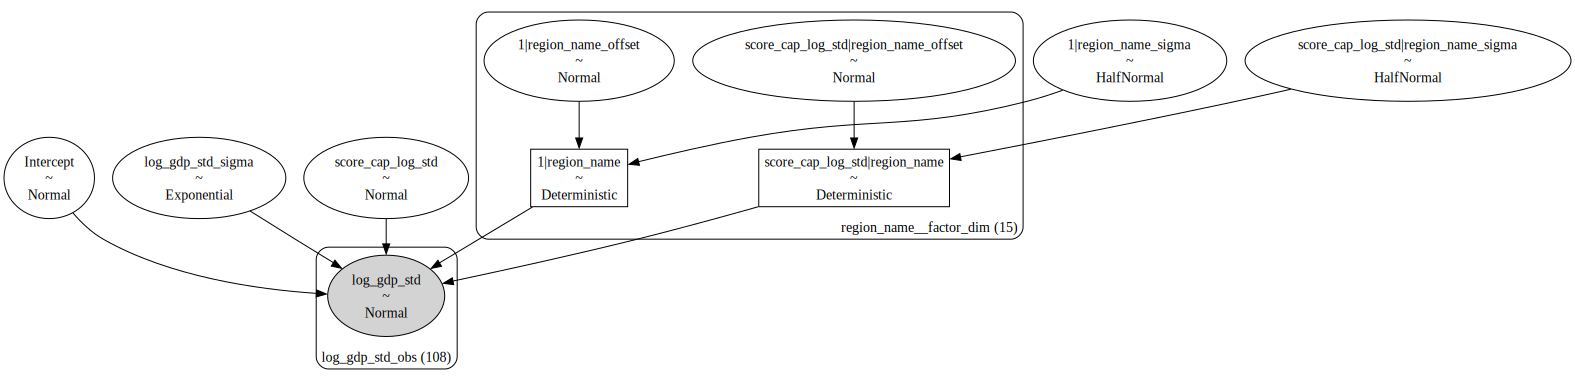

In [288]:
m_score_cap_vs.build()
m_score_cap_vs.graph()

In [289]:
m_score_cap_vs_fit = m_score_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)"] = m_score_cap_vs_fit
az.summary(m_score_cap_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_cap_log_std, 1|region_name_sigma, 1|region_name_offset, score_cap_log_std|region_name_sigma, score_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        1.075  0.028   1.026   
score_cap_log_std                               -0.086  0.025  -0.134   
log_gdp_std_sigma                                0.023  0.002   0.020   
1|region_name_sigma                              0.057  0.017   0.028   
score_cap_log_std|region_name_sigma              0.030  0.019   0.000   
1|region_name[Arabic world]                     -0.030  0.038  -0.100   
1|region_name[Chinese world]                    -0.014  0.040  -0.082   
1|region_name[France]                            0.024  0.028  -0.028   
1|region_name[German world]                      0.006  0.025  -0.042   
1|region_name[Greek World]                       0.058  0.038  -0.014   
1|region_name[Indian world]                     -0.074  0.042  -0.152   
1|region_name[Italy]                             0.024  0.028  -0.031   
1|region_name[Japan]                            -0.000  0.035  -0.066   
1|region_name[Korea]                            -0.016  0.044  -0.093   
1|region_name[Low countries]                     0.048  0.025   0.002   
1|region_name[Nordic countries]                 -0.031  0.025  -0.078   
1|region_name[Persian world]                    -0.046  0.037  -0.116   
1|region_name[Portugal]                         -0.037  0.033  -0.100   
1|region_name[Spain]                            -0.006  0.027  -0.057   
1|region_name[United Kingdom]                    0.088  0.028   0.034   
score_cap_log_std|region_name[Arabic world]     -0.014  0.026  -0.068   
score_cap_log_std|region_name[Chinese world]    -0.002  0.022  -0.045   
score_cap_log_std|region_name[France]           -0.019  0.035  -0.092   
score_cap_log_std|region_name[German world]     -0.006  0.032  -0.071   
score_cap_log_std|region_name[Greek World]       0.013  0.025  -0.032   
score_cap_log_std|region_name[Indian world]      0.034  0.030  -0.009   
score_cap_log_std|region_name[Italy]             0.007  0.030  -0.050   
score_cap_log_std|region_name[Japan]             0.002  0.026  -0.047   
score_cap_log_std|region_name[Korea]            -0.004  0.023  -0.048   
score_cap_log_std|region_name[Low countries]     0.003  0.029  -0.059   
score_cap_log_std|region_name[Nordic countries] -0.006  0.031  -0.070   
score_cap_log_std|region_name[Persian world]    -0.014  0.028  -0.076   
score_cap_log_std|region_name[Portugal]          0.014  0.031  -0.040   
score_cap_log_std|region_name[Spain]            -0.013  0.027  -0.071   
score_cap_log_std|region_name[United Kingdom]    0.005  0.031  -0.056   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          1.132      0.001    0.001   
score_cap_log_std                                 -0.041      0.001    0.001   
log_gdp_std_sigma                                  0.027      0.000    0.000   
1|region_name_sigma                                0.087      0.001    0.000   
score_cap_log_std|region_name_sigma                0.063      0.001    0.001   
1|region_name[Arabic world]                        0.045      0.001    0.001   
1|region_name[Chinese world]                       0.073      0.001    0.001   
1|region_name[France]                              0.075      0.001    0.000   
1|region_name[German world]                        0.053      0.000    0.000   
1|region_name[Greek World]                         0.133      0.001    0.001   
1|region_name[Indian world]                       -0.004      0.002    0.001   
1|region_name[Italy]                               0.074      0.001    0.000   
1|region_name[Japan]                               0.069      0.001    0.001   
1|region_name[Korea]                               0.074      0.001    0.001   
1|region_name[Low countries]                       0.097      0.000    0.000   
1|region_name[Nordic countries]                    0.017      0.001    0.000   
1|region_name[Persian world]                       0.025     

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


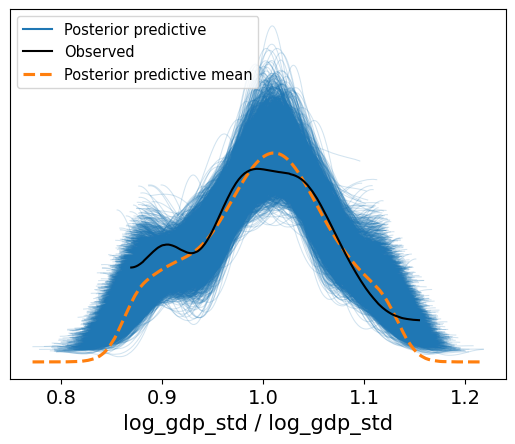

In [290]:
m_score_cap_vs.predict(m_score_cap_vs_fit, kind="pps")
az.plot_ppc(m_score_cap_vs_fit);

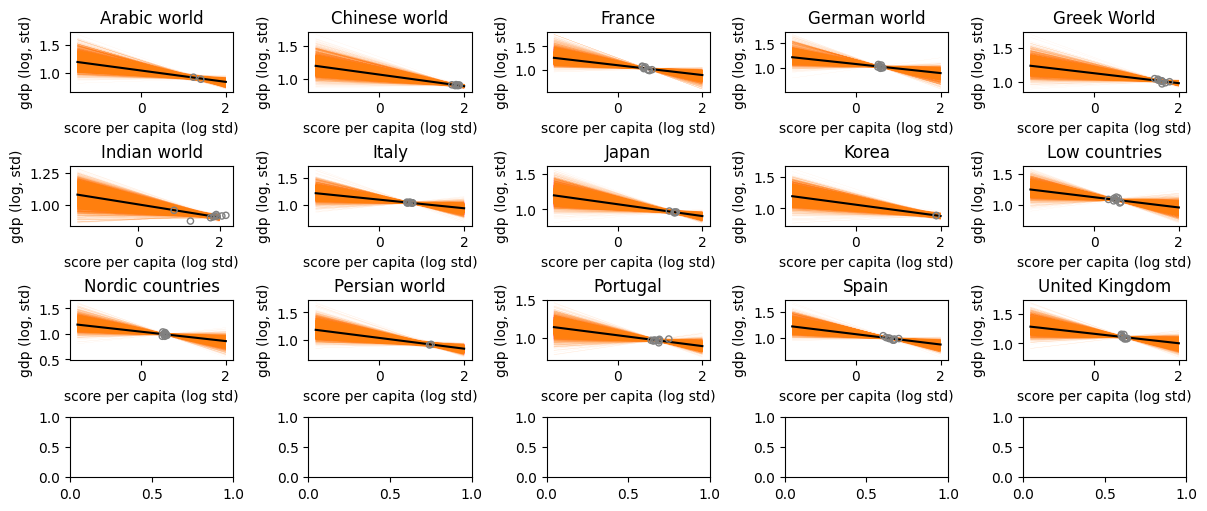

In [291]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

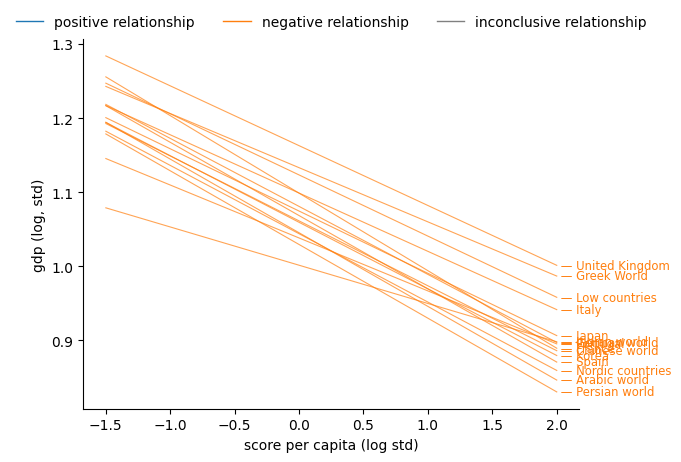

In [292]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score per capita (log std)");

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [293]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vs = bmb.Model(
    "log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_cap_vs

       Formula: log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 108
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_cap_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_cap_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

In [294]:
m_est_cap_vs_fit = m_est_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (N_est_cap_log_std|region_name)"] = m_est_cap_vs_fit
az.summary(m_est_cap_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_cap_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_cap_log_std|region_name_sigma, N_est_cap_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  \
Intercept                                        1.030  0.018   0.994   
N_est_cap_log_std                               -0.043  0.012  -0.067   
log_gdp_std_sigma                                0.022  0.002   0.019   
1|region_name_sigma                              0.057  0.015   0.033   
N_est_cap_log_std|region_name_sigma              0.024  0.013   0.000   
1|region_name[Arabic world]                     -0.022  0.039  -0.095   
1|region_name[Chinese world]                    -0.001  0.045  -0.088   
1|region_name[France]                            0.020  0.020  -0.016   
1|region_name[German world]                     -0.017  0.022  -0.061   
1|region_name[Greek World]                       0.064  0.036  -0.006   
1|region_name[Indian world]                     -0.065  0.030  -0.125   
1|region_name[Italy]                             0.015  0.019  -0.021   
1|region_name[Japan]                             0.010  0.038  -0.059   
1|region_name[Korea]                            -0.003  0.046  -0.091   
1|region_name[Low countries]                     0.049  0.020   0.010   
1|region_name[Nordic countries]                 -0.045  0.020  -0.083   
1|region_name[Persian world]                    -0.036  0.038  -0.103   
1|region_name[Portugal]                         -0.040  0.022  -0.084   
1|region_name[Spain]                            -0.022  0.020  -0.058   
1|region_name[United Kingdom]                    0.097  0.021   0.057   
N_est_cap_log_std|region_name[Arabic world]     -0.009  0.019  -0.049   
N_est_cap_log_std|region_name[Chinese world]     0.005  0.015  -0.023   
N_est_cap_log_std|region_name[France]           -0.025  0.028  -0.079   
N_est_cap_log_std|region_name[German world]     -0.005  0.025  -0.060   
N_est_cap_log_std|region_name[Greek World]       0.010  0.017  -0.018   
N_est_cap_log_std|region_name[Indian world]      0.025  0.015  -0.002   
N_est_cap_log_std|region_name[Italy]             0.005  0.024  -0.036   
N_est_cap_log_std|region_name[Japan]             0.007  0.018  -0.027   
N_est_cap_log_std|region_name[Korea]             0.005  0.015  -0.024   
N_est_cap_log_std|region_name[Low countries]    -0.010  0.021  -0.054   
N_est_cap_log_std|region_name[Nordic countries]  0.004  0.024  -0.041   
N_est_cap_log_std|region_name[Persian world]    -0.009  0.021  -0.051   
N_est_cap_log_std|region_name[Portugal]          0.018  0.021  -0.018   
N_est_cap_log_std|region_name[Spain]            -0.009  0.018  -0.044   
N_est_cap_log_std|region_name[United Kingdom]   -0.008  0.025  -0.064   

                                                 hdi_97%  mcse_mean  mcse_sd  \
Intercept                                          1.063      0.000    0.000   
N_est_cap_log_std                                 -0.022      0.000    0.000   
log_gdp_std_sigma                                  0.025      0.000    0.000   
1|region_name_sigma                                0.085      0.000    0.000   
N_est_cap_log_std|region_name_sigma                0.046      0.000    0.000   
1|region_name[Arabic world]                        0.050      0.001    0.000   
1|region_name[Chinese world]                       0.083      0.001    0.001   
1|region_name[France]                              0.060      0.000    0.000   
1|region_name[German world]                        0.023      0.000    0.000   
1|region_name[Greek World]                         0.131      0.001    0.000   
1|region_name[Indian world]                       -0.012      0.001    0.000   
1|region_name[Italy]                               0.051      0.000    0.000   
1|region_name[Japan]                               0.085      0.001    0.000   
1|region_name[Korea]                               0.085      0.001    0.001   
1|region_name[Low countries]                       0.085      0.000    0.000   
1|region_name[Nordic countries]                   -0.007      0.000    0.000   
1|region_name[Persian world]                       0.038     

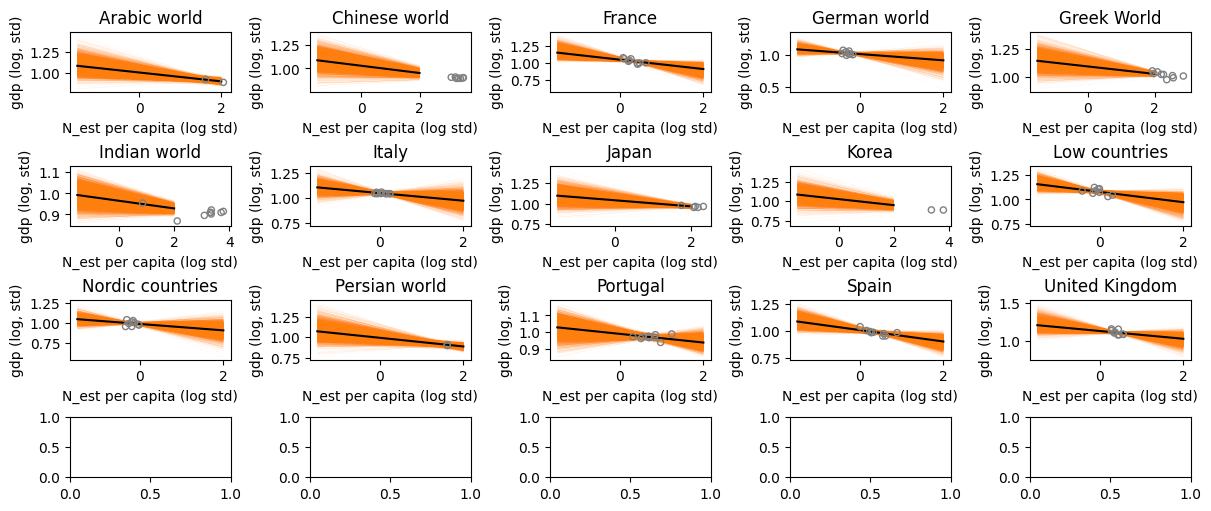

In [295]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)", title=region_name)

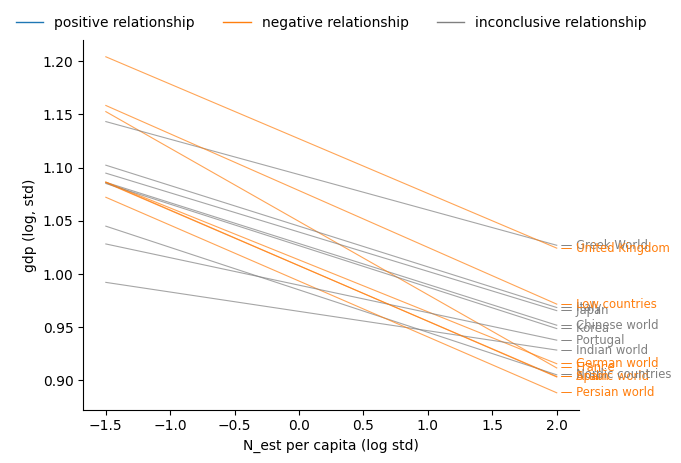

In [296]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)");

fig.savefig('results_BRM/gpd_index_relationship.png')

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models. Furthermore, we note that the bias-correction does not improve the model fit considerably. Finally, representing the cultural scores per capita does not improve the model fit either. 

In [297]:
waic_compare = az.compare(models, ic='LOO')

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn

In [298]:
waic_compare['elpd_loo'] = round(waic_compare['elpd_loo'], 0)

In [299]:
waic_compare

rank  elpd_loo      p_loo  \
log_gdp_std ~ score_log_std + (score_log_std|re...     0     270.0  20.039638   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1     268.0  15.545708   
log_gdp_std ~ N_est_log_std + (1|region_name)          2     268.0  14.307154   
log_gdp_std ~ score_log_std + (1|region_name)          3     266.0  14.515635   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...     4     248.0  17.430018   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     5     245.0  15.874710   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)      6     244.0  14.229745   
log_gdp_std ~ score_cap_log_std + (1|region_name)      7     242.0  14.517578   
log_gdp_std ~ (1|region_name)                          8     239.0  13.364283   
gdp ~ score_log_std                                    9     179.0   2.414651   
gdp ~ N_est_log_std                                   10     177.0   2.398114   

                                                    elpd_diff        weight  \
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000  7.574603e-01   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...   2.182803  2.071874e-10   
log_gdp_std ~ N_est_log_std + (1|region_name)        2.282370  1.914094e-01   
log_gdp_std ~ score_log_std + (1|region_name)        4.937871  2.011332e-10   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  22.000232  2.654238e-10   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  25.723819  2.641754e-10   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   26.448517  2.651689e-10   
log_gdp_std ~ score_cap_log_std + (1|region_name)   28.480146  2.661935e-10   
log_gdp_std ~ (1|region_name)                       31.259774  5.113023e-02   
gdp ~ score_log_std                                 91.367596  0.000000e+00   
gdp ~ N_est_log_std                                 93.108921  0.000000e+00   

                                                          se       dse  \
log_gdp_std ~ score_log_std + (score_log_std|re...  7.724455  0.000000   
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  7.294100  2.857917   
log_gdp_std ~ N_est_log_std + (1|region_name)       7.237373  3.190419   
log_gdp_std ~ score_log_std + (1|region_name)       7.946752  3.267002   
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...  7.523816  6.936310   
log_gdp_std ~ score_cap_log_std + (score_cap_lo...  7.980048  7.339846   
log_gdp_std ~ N_est_cap_log_std + (1|region_name)   7.643869  7.263250   
log_gdp_std ~ score_cap_log_std + (1|region_name)   8.074221  7.637696   
log_gdp_std ~ (1|region_name)                       6.835149  7.421909   
gdp ~ score_log_std                                 5.862221  7.903408   
gdp ~ N_est_log_std                                 6.359070  8.203340   

                                                    warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...     True   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)         False   log  
log_gdp_std ~ score_log_std + (1|region_name)         False   log  
log_gdp_std ~ N_est_cap_log_std + (N_est_cap_lo...    False   log  
log_gdp_std ~ score_cap_log_std + (score_cap_lo...     True   log  
log_gdp_std ~ N_est_cap_log_std + (1|region_name)     False   log  
log_gdp_std ~ score_cap_log_std + (1|region_name)     False   log  
log_gdp_std ~ (1|region_name)                         False   log  
gdp ~ score_log_std                                   False   log  
gdp ~ N_est_log_std                                   False   log

/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)
/Users/charlesdedampierre/Desktop/cultura_project/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


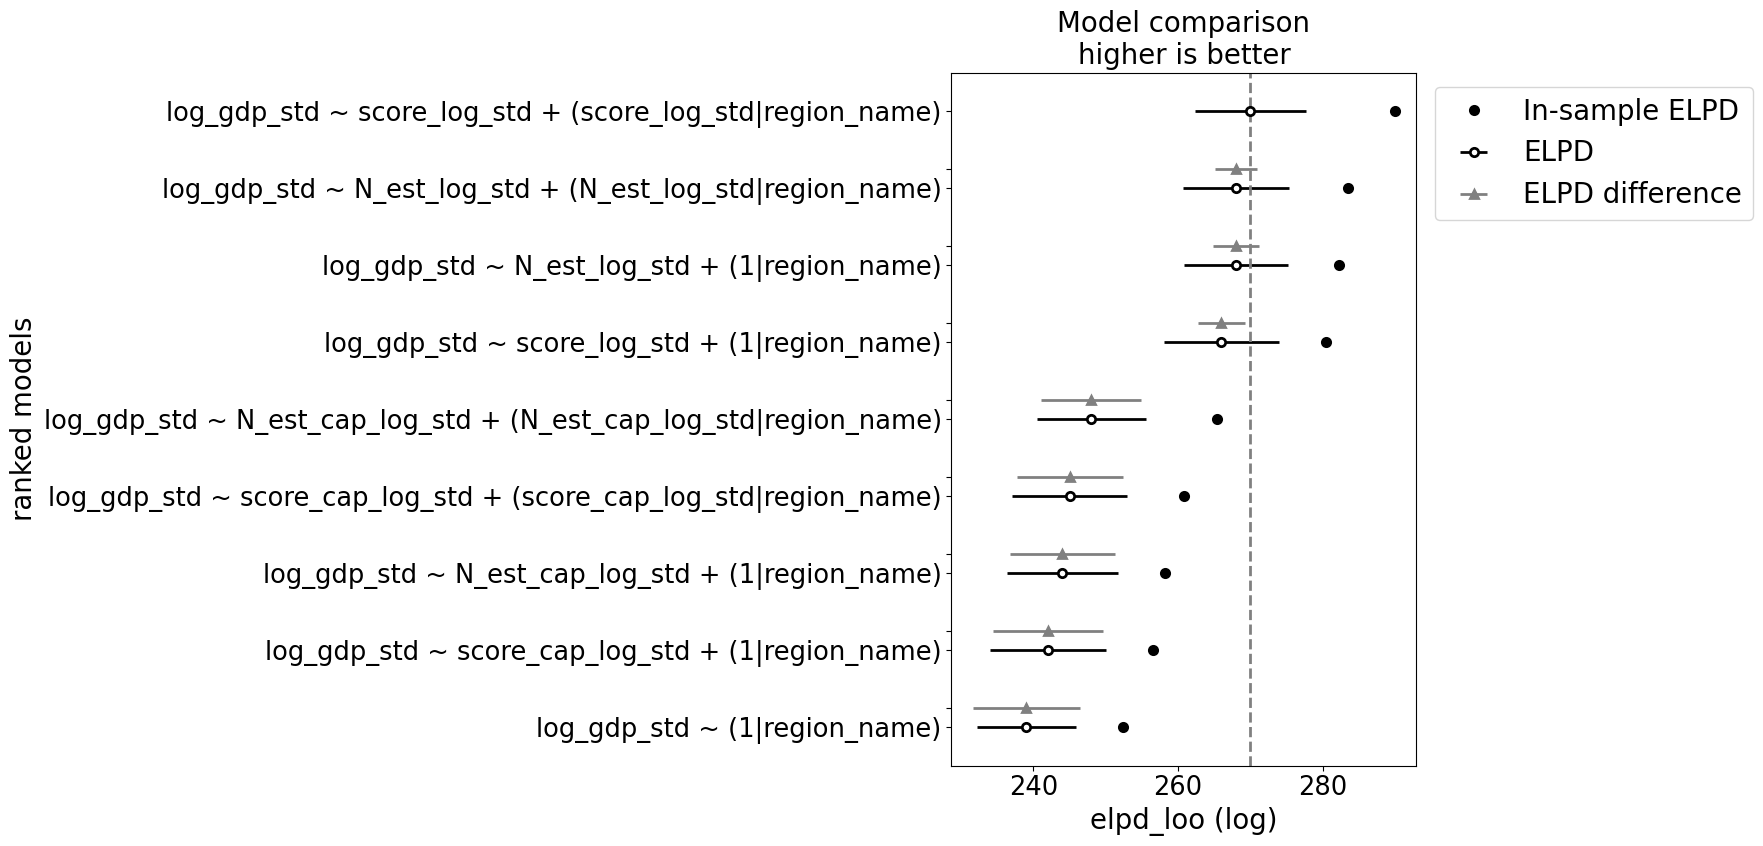

In [300]:
# Your existing code to create the plot
axes = az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True)

# Get the figure from the axes
fig = axes.figure

In [301]:
# Save the figure to a file
fig.savefig('results_BRM/model_comparison', dpi=300) 